In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from scipy.spatial import cKDTree
import cupy as cp

In [2]:
class Sperm2D:
    def __init__(self,
                 length=65,
                 n_segments=50,
                 bending_modulus=1800,
                 amplitude=0.2,
                 wavenumber=1.0, # Note: not the conventional wavenumner. 2*pi*k*l/L, where k is the wavenumber
                 frequency=1.0,
                 init_position=[0.0, 0.0], # tip of head
                 init_angle=0.0,
                 phase=0.0,
                 head_semi_major=3.0,
                 head_semi_minor=1.0): # Also the tail radius
        """
        Initialize a single 2D sperm filament.

        Parameters
        ----------
        length : float (default=70.1)
            Total length of the filament (L).
        n_segments : int (default = 50)
            Number of discrete segments (N).
        bending_modulus : float (default = 1800)
            Bending stiffness K_B.
        amplitude, wavenumber, frequency, phase : floats (defaults = 0.2, 1.0, 1.0, 0)
            Parameters for the preferred-curvature waveform kappa(s,t).
        init_position : list of 2 elements (default = [0, 0])
            Initial position of the head tip of sperm
        init_angle: float (default = 0)
            Initial angle of the sperm
        head_semi_major, head_semi_minor: floats (defaults = 3, 1)
            radius of head and flagellum segments
        """
        # Geometry
        self.L = length
        self.N_flag = n_segments
        self.Delta_L = length / n_segments
        self.a = head_semi_major
        self.b = head_semi_minor

        # Radius and length of all segments
        self.radii = np.hstack([self.a, [self.b]*self.N_flag])
        self.lengths = np.hstack([2*self.a, [self.Delta_L]*self.N_flag])

        # Mechanical parameters
        self.K_B = bending_modulus
        self.K_0 = amplitude
        self.k = wavenumber
        self.omega = frequency
        self.phi = phase

        # State: positions Y[0..N], angles theta[0..N]
        self.Y_0 = init_position
        self.theta_0 = init_angle
        coordinates = np.hstack([self.a, np.arange(2.1*self.a, self.L+2.101*self.a, self.Delta_L)]) # Extra 0.1a to account for the linkage between the flagellum and the head
        self.Y = np.vstack([self.Y_0[0]+coordinates*np.cos(self.theta_0), self.Y_0[1]+coordinates*np.sin(self.theta_0)]).T # An array of length 2N+3 (midpoint and edges of segmenets)
        self.theta = np.array([init_angle]*(self.N_flag+1)) # An array of length N+1 (midpoint of segments)

        # Lagrange multipliers for constraints (N+2 of them), corresponding to the edges of each segment
        self.Lambda = np.zeros((self.N_flag+2, 2))

    def preferred_curvature(self, t):
        """
        Preferred curvature Kappa(s,t) along filament using Eq. 2.1 of Schoeller et al. 2018
        Returns an array of length N, corresponding to the midpoint of each filament segment only, i.e. no head.
        """
        s = np.arange(self.Delta_L/2, self.L, self.Delta_L)
        base = self.K_0 * np.sin(2*np.pi*self.k*s/self.L - self.omega*t+self.phi)
        decay = np.where(s > self.L/2, 1.0, 2*s/self.L)
        kappa = base * decay
        return kappa

    def internal_moment(self, t):
        """
        Compute M_{n+1/2} for n=1..N+1 using Eq. 34 of Schoeller et al. 2020
        Returns an array of length N+2, corresponding to the edges of each segment.
        """
        kappa = self.preferred_curvature(t)
        t_hat_x, t_hat_y = np.cos(self.theta), np.sin(self.theta)
        cross = t_hat_x[:-1]*t_hat_y[1:] - t_hat_y[:-1]*t_hat_x[1:]
        delta_s = self.lengths[1:]
        delta_s[0] = 1.1*self.a + 0.5*self.Delta_L
        M = np.zeros(self.N_flag+2)
        M[1:-1] = self.K_B * (cross/delta_s - kappa)
        return M

    def reconstruct_midpoints(self, Y1, theta):
        '''
        Compute all midpoints from Y1 and theta.

        Parameters
        ----------
        Y1 : ndarray, shape (2, )
            The coordinates of the midpoint of the head segment.
        theta: ndarray, shape (N+1, )
            The angular position of the midpoint of each segment.
        Returns
        -------
        Y : ndarray, shape (N+1, 2)
            The coordinates of the midpoint of each segment, head inclusive.
        '''
        t_hat = np.column_stack([np.cos(theta), np.sin(theta)])
        disp = np.zeros_like(t_hat)
        disp[1] = 0.5*(1.1*self.a+0.5*self.Delta_L)*(t_hat[0]+t_hat[1])
        disp[2:] = 0.5*self.Delta_L*(t_hat[1:-1] + t_hat[2:])
        return Y1 + np.cumsum(disp, axis=0)

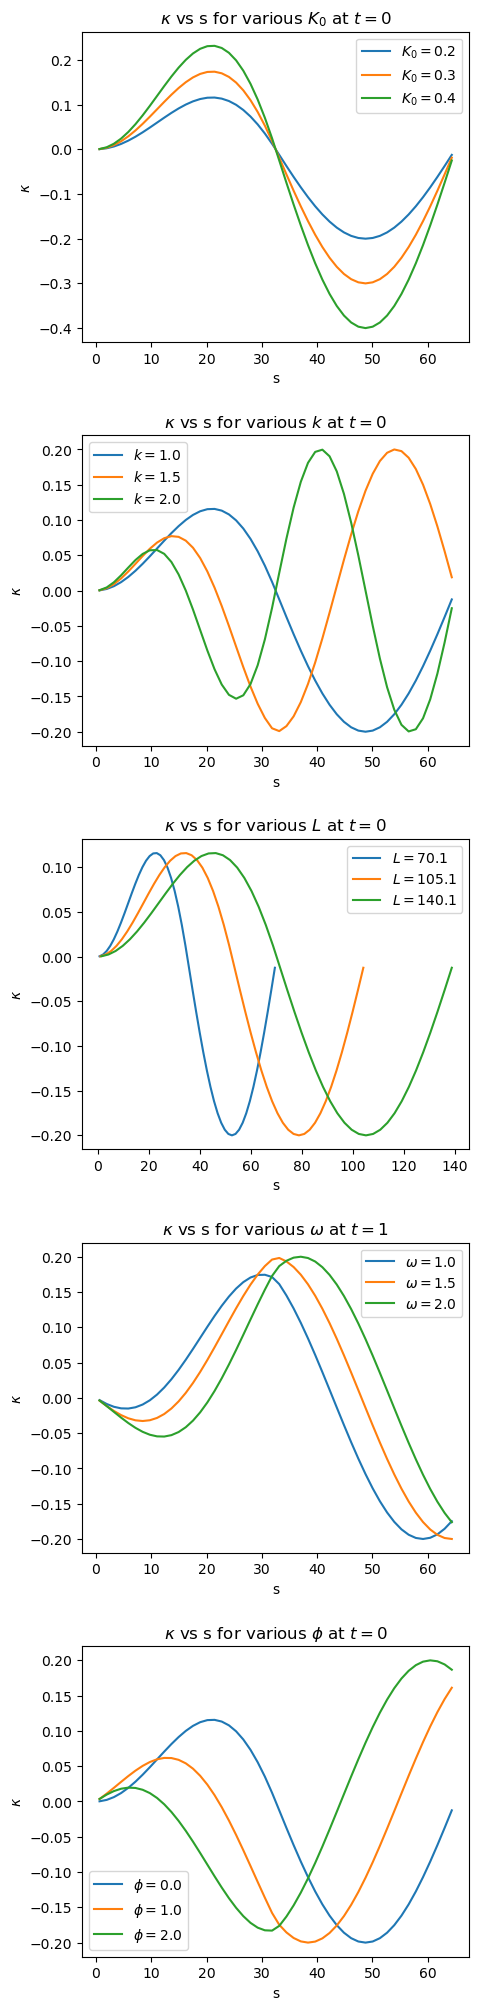

In [3]:
# kappa vs s graphs. Check preferred_curvature method
fig, ax = plt.subplots(5, 1, figsize=(5, 25))
plt.subplots_adjust(hspace=0.3)

# Different K_0
for i in range(3):
    amplitude = 0.2+i*0.1
    sperm = Sperm2D(amplitude=amplitude)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(0)
    ax[0].plot(s, kappa, label=f"$K_0={amplitude:.1f}$")
    ax[0].set_title(r'$\kappa$ vs s for various $K_0$ at $t=0$')
    ax[0].set_xlabel('s')
    ax[0].set_ylabel(r'$\kappa$')
    ax[0].legend()

# Different k
for i in range(3):
    wavenumber = 1.0+i*0.5
    sperm = Sperm2D(wavenumber=wavenumber)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(0)
    ax[1].plot(s, kappa, label=f"$k={wavenumber:.1f}$")
    ax[1].set_title(r'$\kappa$ vs s for various $k$ at $t=0$')
    ax[1].set_xlabel('s')
    ax[1].set_ylabel(r'$\kappa$')
    ax[1].legend()

# Different L
for i in range(3):
    length = 70.1+i*35
    sperm = Sperm2D(length=length)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(0)
    ax[2].plot(s, kappa, label=f"$L={length:.1f}$")
    ax[2].set_title(r'$\kappa$ vs s for various $L$ at $t=0$')
    ax[2].set_xlabel('s')
    ax[2].set_ylabel(r'$\kappa$')
    ax[2].legend()

# Different omega
for i in range(3):
    frequency = 1.0+0.5*i
    sperm = Sperm2D(frequency=frequency)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(1)
    ax[3].plot(s, kappa, label=f"$\\omega={frequency:.1f}$")
    ax[3].set_title(r'$\kappa$ vs s for various $\omega$ at $t=1$')
    ax[3].set_xlabel('s')
    ax[3].set_ylabel(r'$\kappa$')
    ax[3].legend()

# Different phi
for i in range(3):
    phase = i
    sperm = Sperm2D(phase=phase)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(0)
    ax[4].plot(s, kappa, label=f"$\\phi={phase:.1f}$")
    ax[4].set_title(r'$\kappa$ vs s for various $\phi$ at $t=0$')
    ax[4].set_xlabel('s')
    ax[4].set_ylabel(r'$\kappa$')
    ax[4].legend()

plt.show()

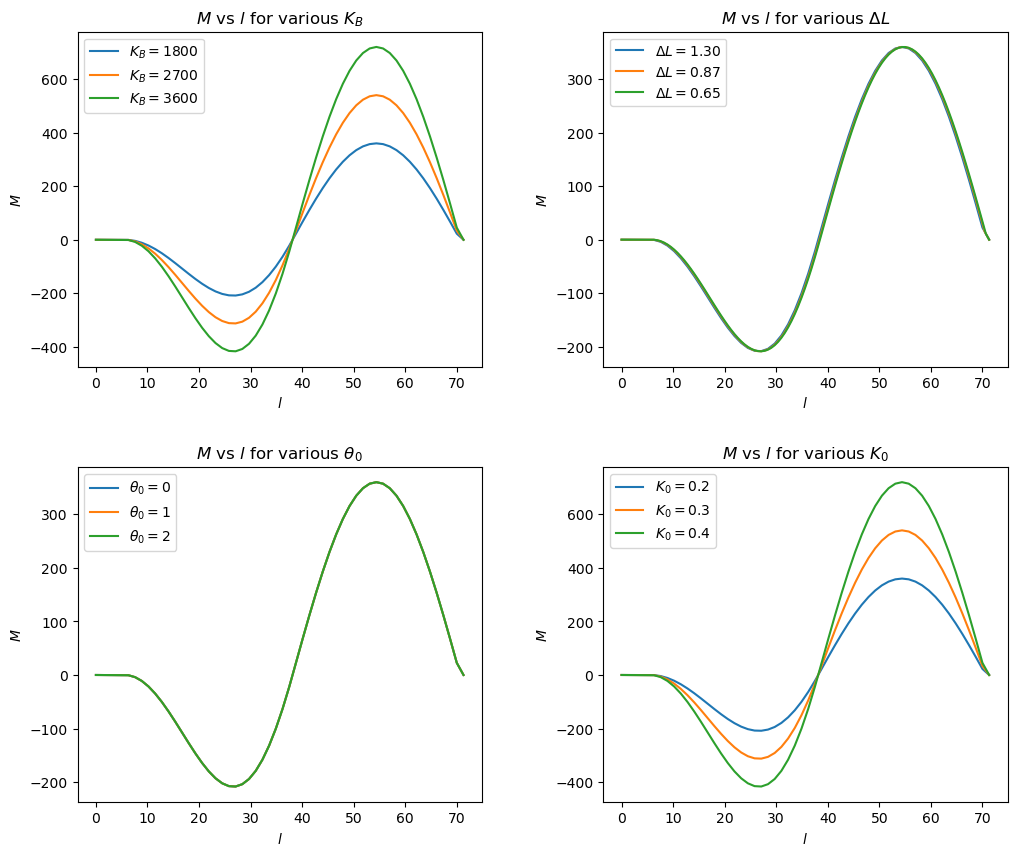

In [4]:
# M vs l graphs. Check internal_moment method
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Different K_B
for i in range(3):
    bending_modulus = 1800+i*900
    sperm = Sperm2D(bending_modulus=bending_modulus)
    l = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    M = sperm.internal_moment(0)
    ax[0, 0].plot(l, M, label=f"$K_B={bending_modulus}$")
    ax[0, 0].set_title(r'$M$ vs $l$ for various $K_B$')
    ax[0, 0].set_xlabel(r'$l$')
    ax[0, 0].set_ylabel(r'$M$')
    ax[0, 0].legend()

# Different Delta L
for i in range(3):
    n_segments = 50+25*i
    sperm = Sperm2D(n_segments=n_segments)
    l = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    M = sperm.internal_moment(0)
    ax[0, 1].plot(l, M, label=f"$\\Delta L={sperm.Delta_L:.2f}$")
    ax[0, 1].set_title(r'$M$ vs $l$ for various $\Delta L$')
    ax[0, 1].set_xlabel(r'$l$')
    ax[0, 1].set_ylabel(r'$M$')
    ax[0, 1].legend()

# Different init_angle
for i in range(3):
    init_angle = i
    sperm = Sperm2D(init_angle=init_angle)
    l = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    M = sperm.internal_moment(0)
    ax[1, 0].plot(l, M, label=f"$\\theta_0={init_angle}$")
    ax[1, 0].set_title(r'$M$ vs $l$ for various $\theta_0$')
    ax[1, 0].set_xlabel(r'$l$')
    ax[1, 0].set_ylabel(r'$M$')
    ax[1, 0].legend()

# Different kappa, varied by varying K_0
for i in range(3):
    amplitude = 0.2+i*0.1
    sperm = Sperm2D(amplitude=amplitude)
    l = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    M = sperm.internal_moment(0)
    ax[1, 1].plot(l, M, label=f"$K_0={amplitude:.1f}$")
    ax[1, 1].set_title(r'$M$ vs $l$ for various $K_0$')
    ax[1, 1].set_xlabel(r'$l$')
    ax[1, 1].set_ylabel(r'$M$')
    ax[1, 1].legend()

plt.show()

In [5]:
@nb.njit
def calc_F_B(positions, radii, F_S, chi, neighbors, chi2m1, F_B):
    '''
    Helper function for barrier_force to run for loop efficiently.
    '''
    for i in range(neighbors.shape[0]):
        n = neighbors[i,0]
        m = neighbors[i,1]
        if abs(n-m)==1:
            continue
        contact = radii[n] + radii[m]
        r_threshold = chi*contact
        # compute diff and dist
        dx = positions[n, 0] - positions[m, 0]
        dy = positions[n, 1] - positions[m, 1]
        dist_nm = np.sqrt(dx*dx + dy*dy)  # 2D
        if (dist_nm > 0.0) and (dist_nm < r_threshold):
            num   = r_threshold*r_threshold - dist_nm*dist_nm
            denom = contact*contact * chi2m1
            mag   = F_S * (num/denom)**4 / contact
            F_x, F_y = mag * dx, mag * dy
            F_B[n,0] +=  F_x
            F_B[n,1] +=  F_y
            F_B[m,0] -=  F_x
            F_B[m,1] -=  F_y
    return F_B

In [6]:
def barrier_force(positions, radii, F_S, chi):
    """
    Compute steric barrier forces, treating index 0 as head and others as tail.
    Assume no repulsion due to head-on tail-tail/head-tail interactions. Fair assumption since there're few such interactions.

    Parameters
    ----------
    positions : array, shape (N+1, 2)
        Coordinates of N+1 segment midpoints in 2D.
    radii: array, shape (N+1, )
        radius of each segment. The first segment is the head, the rest are all tails.
    F_S : float
        Reference strength of the repulsive force.
    chi : float
        Range factor.

    Returns
    -------
    forces : ndarray, shape (N+1, 2)
        Steric barrier force on the midpoint of each segment.
    """
    F_B = np.zeros_like(positions)
    chi2m1 = chi**2 - 1
    tree = cKDTree(positions)
    neighbors = np.array(list(tree.query_pairs(r=chi*2*radii[0], output_type='ndarray')))
    F_B = calc_F_B(positions, radii, F_S, chi, neighbors, chi2m1, F_B)
    return F_B

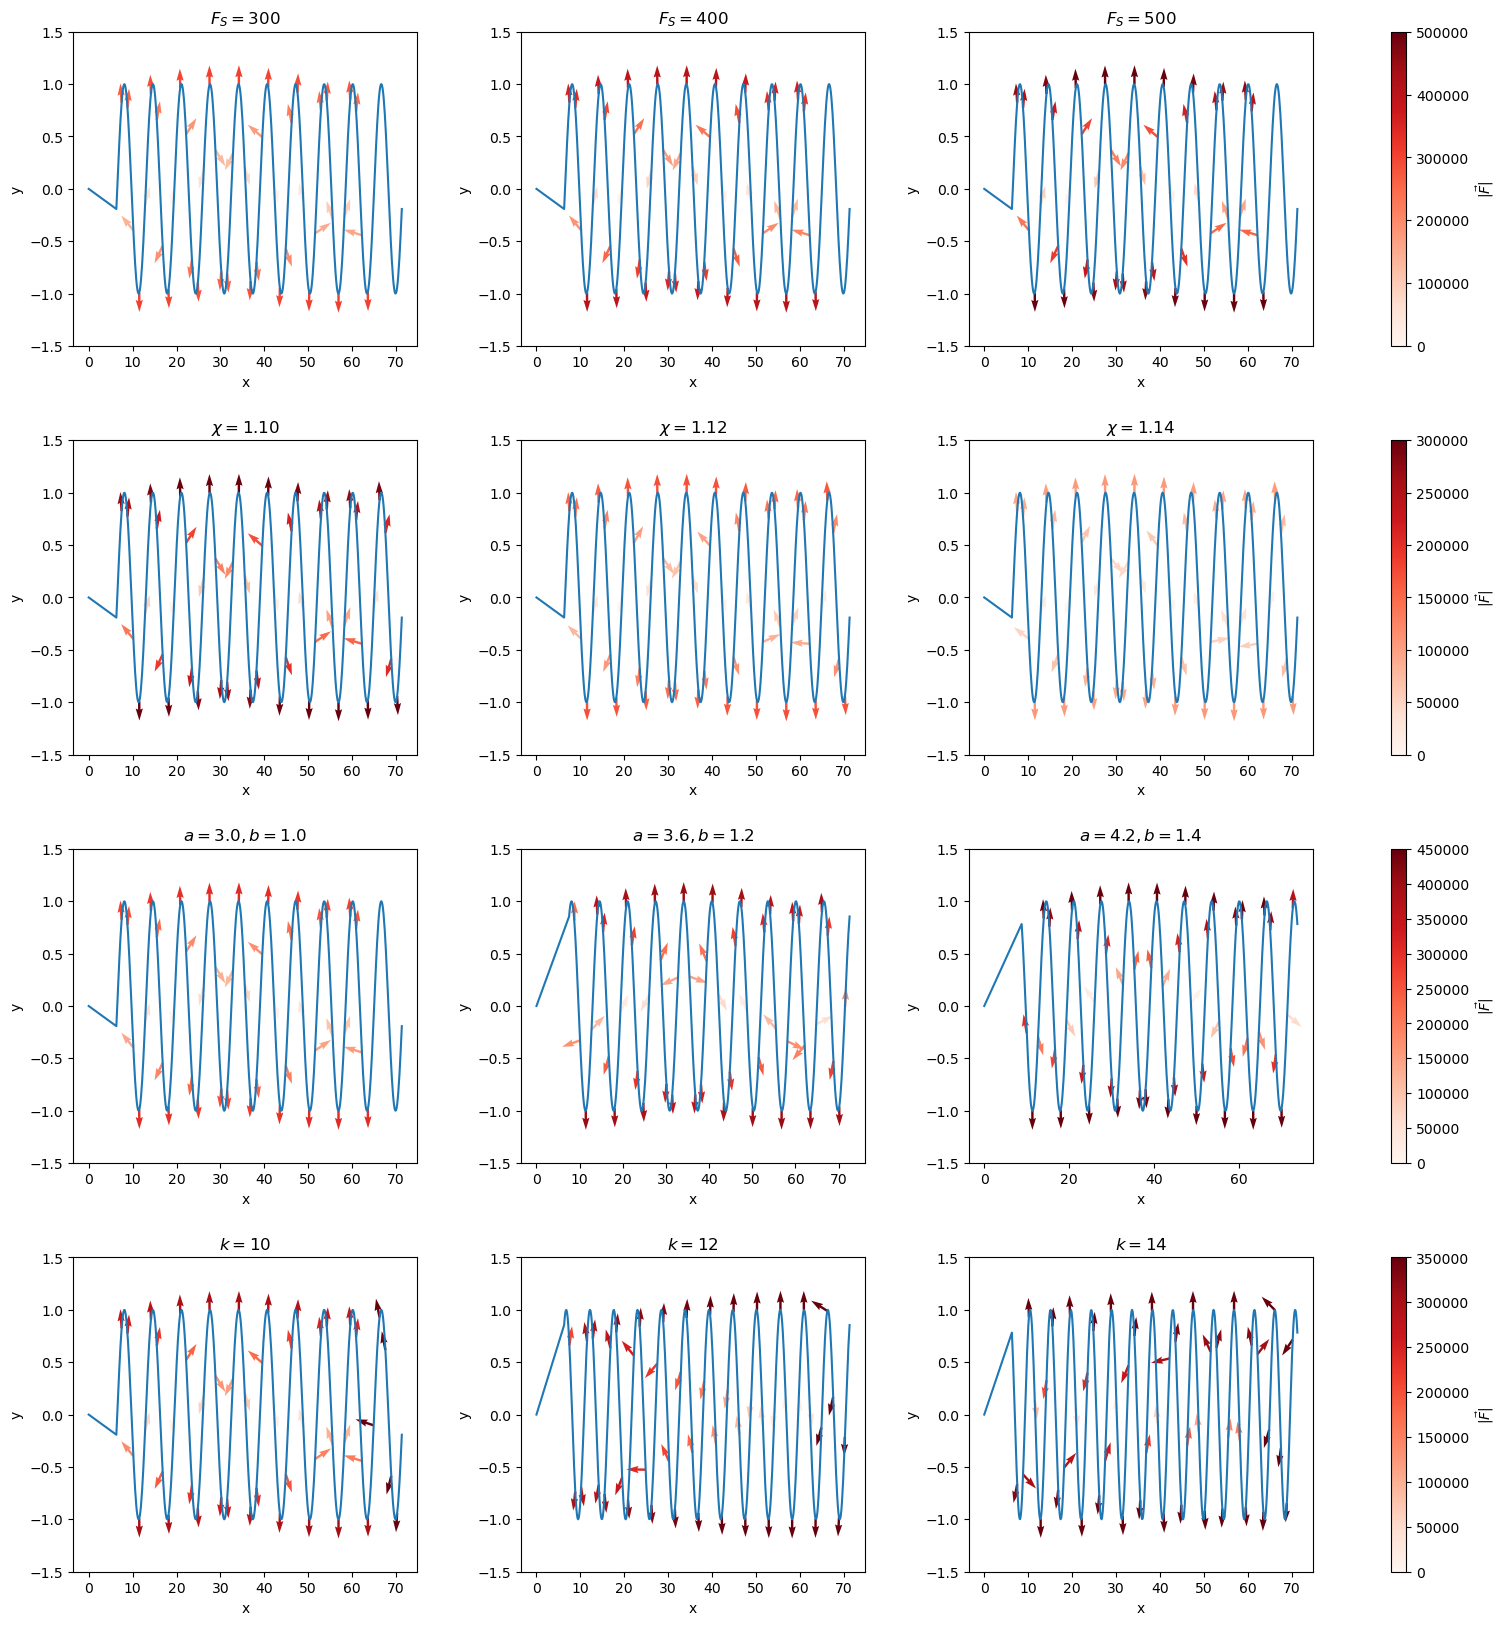

In [7]:
# force field plot. Check barrier_force method
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Different F_S
chi = 1.1
A = 1
k = 10
sperm = Sperm2D(n_segments=487)
x = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
y = A*np.sin(2*np.pi*k*x/sperm.L)
s = np.vstack([x, y]).T
for i in range(3):
    F_S = 300+i*100
    F_B = barrier_force(s, sperm.radii, F_S, chi)
    mag = np.sqrt(F_B[::10,0]**2+F_B[::10,1]**2)
    mask = mag > 0
    F_B_hat_x = F_B[::10,0][mask] / mag[mask]
    F_B_hat_y = F_B[::10,1][mask] / mag[mask]
    Q = ax[0, i].quiver(
    x[::10][mask], y[::10][mask],        # origins
    F_B_hat_x, F_B_hat_y,    # arrow components
    mag[mask],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.007,
    clim=(0, int(5e5)),
    )
    ax[0, i].plot(x, y)
    ax[0, i].set_ylim([-1.5, 1.5])
    ax[0, i].set_xlabel('x')
    ax[0, i].set_ylabel('y')
    ax[0, i].set_title(f'$F_S={F_S}$')
cbar = fig.colorbar(Q, ax=ax[0,:], label=r'$|\vec{F}|$')

# Different chi
F_S = 300
A = 1
k = 10
sperm = Sperm2D(n_segments=487)
x = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
y = A*np.sin(2*np.pi*k*x/sperm.L)
s = np.vstack([x, y]).T
for i in range(3):
    chi = 1.1+i*0.02
    F_B = barrier_force(s, sperm.radii, F_S, chi)
    mag = np.sqrt(F_B[::10,0]**2+F_B[::10,1]**2)
    mask = mag > 0
    F_B_hat_x = F_B[::10,0][mask] / mag[mask]
    F_B_hat_y = F_B[::10,1][mask] / mag[mask]
    Q = ax[1, i].quiver(
    x[::10][mask], y[::10][mask],        # origins
    F_B_hat_x, F_B_hat_y,    # arrow components
    mag[mask],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.007,
    clim=(0, int(3e5)),
    )
    ax[1, i].plot(x, y)
    ax[1, i].set_ylim([-1.5, 1.5])
    ax[1, i].set_xlabel('x')
    ax[1, i].set_ylabel('y')
    ax[1, i].set_title(f'$\\chi={chi:.2f}$')
cbar = fig.colorbar(Q, ax=ax[1,:], label=r'$|\vec{F}|$')

# Different a, b
F_S = 300
A = 1
k = 10
chi = 1.1
for i in range(3):
    sperm = Sperm2D(n_segments=487, head_semi_major=3+i*0.6, head_semi_minor=1+i*0.2)
    x = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    y = A*np.sin(2*np.pi*k*x/sperm.L)
    s = np.vstack([x, y]).T
    F_B = barrier_force(s, sperm.radii, F_S, chi)
    mag = np.sqrt(F_B[::10,0]**2+F_B[::10,1]**2)
    mask = mag > 0
    F_B_hat_x = F_B[::10,0][mask] / mag[mask]
    F_B_hat_y = F_B[::10,1][mask] / mag[mask]
    Q = ax[2, i].quiver(
    x[::10][mask], y[::10][mask],        # origins
    F_B_hat_x, F_B_hat_y,    # arrow components
    mag[mask],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.007,
    clim=(0, int(4.5e5)),
    )
    ax[2, i].plot(x, y)
    ax[2, i].set_ylim([-1.5, 1.5])
    ax[2, i].set_xlabel('x')
    ax[2, i].set_ylabel('y')
    ax[2, i].set_title(f'$a={sperm.a:.1f}, b={sperm.b:.1f}$')
cbar = fig.colorbar(Q, ax=ax[2,:], label=r'$|\vec{F}|$')

# Different k
F_S = 300
A = 1
chi = 1.1
sperm = Sperm2D(n_segments=487, head_semi_major=3, head_semi_minor=1)
x = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
for i in range(3):
    k = 10+i*2
    y = A*np.sin(2*np.pi*k*x/sperm.L)
    s = np.vstack([x, y]).T
    F_B = barrier_force(s, sperm.radii, F_S, chi)
    mag = np.sqrt(F_B[::10,0]**2+F_B[::10,1]**2)
    mask = mag > 0
    F_B_hat_x = F_B[::10,0][mask] / mag[mask]
    F_B_hat_y = F_B[::10,1][mask] / mag[mask]
    Q = ax[3, i].quiver(
    x[::10][mask], y[::10][mask],        # origins
    F_B_hat_x, F_B_hat_y,    # arrow components
    mag[mask],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.007,
    clim=(0, int(3.5e5)),
    )
    ax[3, i].plot(x, y)
    ax[3, i].set_ylim([-1.5, 1.5])
    ax[3, i].set_xlabel('x')
    ax[3, i].set_ylabel('y')
    ax[3, i].set_title(f'$k={k}$')
cbar = fig.colorbar(Q, ax=ax[3,:], label=r'$|\vec{F}|$')

plt.show()

In [8]:
def constraint_force(Lambda):
    """
    Given internal force at edges, Lambda of length (N+2),
    returns constraint forces F_C on each of the N+1 segments.

    Parameters
    ----------
    Lambda : ndarray, shape (N+2, 2)
        By free-end BCs, M[0] and M[N+1] should be zero.

    Returns
    -------
    F_C : ndarray, shape (N+1, 2)
        Constraint forces at the midpoint of each segment.
    """
    F_C = Lambda[1:] - Lambda[:-1]
    return F_C

In [9]:
def elastic_torque(M):
    """
    Given bending moments at edges, M of length (N+2),
    returns elastic torques T_E on each of the N+1 segments.

    Parameters
    ----------
    M : ndarray, shape (N+2,)
        By free-end BCs, M[0] and M[N+1] should be zero.

    Returns
    -------
    T_E : ndarray, shape (N+1,)
        Elastic torques at the midpoint of each segment.
    """
    T_E = M[1:] - M[:-1]
    return T_E

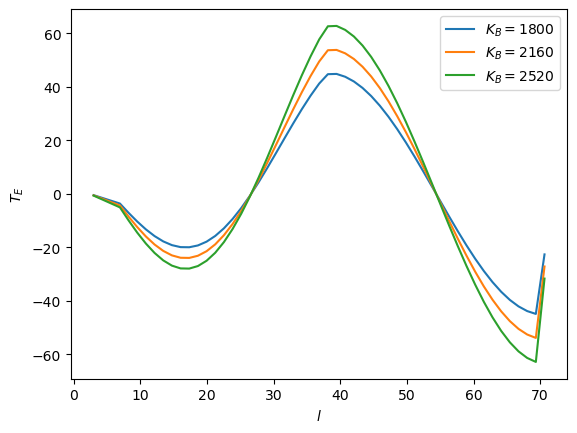

In [10]:
# T_E vs l graphs
# Different M
for i in range(3):
    bending_modulus = 1800+360*i
    sperm = Sperm2D(bending_modulus=bending_modulus)
    l = np.hstack([sperm.a, np.arange(2.1*sperm.a+sperm.Delta_L/2, sperm.L+2.1*sperm.a, sperm.Delta_L)])
    T_E = elastic_torque(sperm.internal_moment(0))
    plt.plot(l, T_E, label=f'$K_B={bending_modulus}$')
    plt.xlabel(r'$l$')
    plt.ylabel(r'$T_E$')
plt.legend()
plt.show()

In [11]:
def constraint_torque(Lambda, angles, lengths):
    """
    Vectorized compute of constraint torques T_C on each segment midpoint.

    Parameters
    ----------
    Lambda : ndarray, shape (N+2, 2)
        Constraint multiplier at each segment edge, inclusive of head (0…N+1).
    angles : ndarray, shape (N+1,)
        Tangent angles at each segment midpoint, head inclusive (0…N).
    lengths: ndarray, shape (N+1, )
        the length of each segment
        
    Returns
    -------
    T_C : ndarray, shape (N+1,)
        Scalar torque on each segment midpoint, head inclusive.
    """
    # Sum adjacent Lambdas: shape (N+1, 2)
    lam_sum = Lambda[:-1] + Lambda[1:]

    # Tangent unit vector components: shape (N+1,)
    t_hat_x = np.cos(angles)
    t_hat_y = np.sin(angles)

    # Cross product t × lam_sum  in 2D: t_x*lam_y - t_y*lam_x
    torques = t_hat_x * lam_sum[:,1] - t_hat_y * lam_sum[:,0]

    T_C = 0.5 * lengths * torques
    return T_C

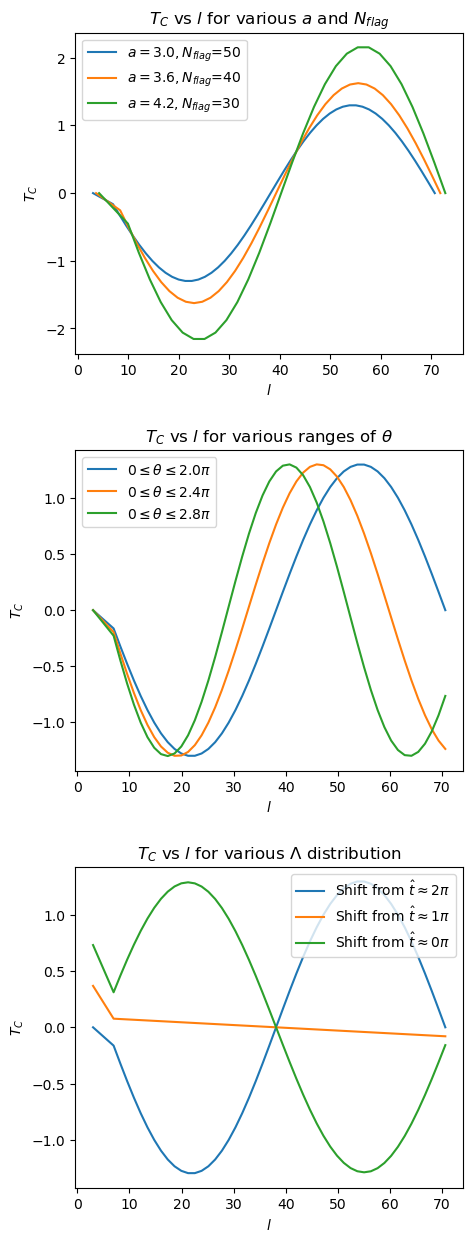

In [12]:
# M vs l graphs. Check internal_moment method
fig, ax = plt.subplots(3, 1, figsize=(5, 15))
plt.subplots_adjust(hspace=0.3)

# Different a and Delta_L
for i in range(3):
    head_semi_major = 3+i*0.6
    n_segments = 50 - i*10
    sperm = Sperm2D(n_segments=n_segments, head_semi_major=head_semi_major)
    l = np.hstack([sperm.a, np.arange(2.1*sperm.a+0.5*sperm.Delta_L, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    Lambda = np.zeros((n_segments+2, 2))
    Lambda[:, 0] = 1
    angles = np.linspace(0, 2*np.pi, n_segments+1)
    T_C = constraint_torque(Lambda, angles, sperm.lengths, sperm.N_flag)
    ax[0].plot(l, T_C, label=f"$a={head_semi_major},$" + r'$N_{flag}$=' + f"${n_segments}$")
    ax[0].set_title(r'$T_C$ vs $l$ for various $a$ and $N_{flag}$')
    ax[0].set_xlabel(r'$l$')
    ax[0].set_ylabel(r'$T_C$')
    ax[0].legend()

# Different angles
for i in range(3):
    sperm = Sperm2D()
    l = np.hstack([sperm.a, np.arange(2.1*sperm.a+0.5*sperm.Delta_L, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    Lambda = np.zeros((sperm.N_flag+2, 2))
    Lambda[:, 0] = 1
    angles = np.linspace(0, (2+i*0.4)*np.pi, sperm.N_flag+1)
    T_C = constraint_torque(Lambda, angles, sperm.lengths, sperm.N_flag)
    ax[1].plot(l, T_C, label=f"$0 \\leq \\theta \\leq {(2+i*0.4)}\\pi$")
    ax[1].set_title(r'$T_C$ vs $l$ for various ranges of $\theta$')
    ax[1].set_xlabel(r'$l$')
    ax[1].set_ylabel(r'$T_C$')
    ax[1].legend()

# Different Lambda
for i in range(3):
    sperm = Sperm2D()
    l = np.hstack([sperm.a, np.arange(2.1*sperm.a+0.5*sperm.Delta_L, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    Lambda = np.zeros((sperm.N_flag+2, 2))
    gen_lamb = i*np.linspace(0, 2*np.pi, sperm.N_flag+2)
    Lambda[:, 0] = np.cos(gen_lamb)
    Lambda[:, 1] = np.sin(gen_lamb)
    angles = np.linspace(0, 2*np.pi, sperm.N_flag+1)
    T_C = constraint_torque(Lambda, angles, sperm.lengths, sperm.N_flag)
    ax[2].plot(l, T_C, label=r"Shift from $\hat{t}\approx$"+f"{2-i}"+r"$\pi$")
    ax[2].set_title(r'$T_C$ vs $l$ for various $\Lambda$ distribution')
    ax[2].set_xlabel(r'$l$')
    ax[2].set_ylabel(r'$T_C$')
    ax[2].legend()

plt.show()

In [13]:
def fcm_spread(
    F_seg, T_seg, coords,
    L_x, L_y, N_x, N_y, sigma_D, sigma_T
    ):
    """
    Calculate the spread of FCM force & torque onto a periodic 2D grid using convolution theorem.

    Parameters
    ----------
    F_seg : numpy.ndarray, shape (N+1, 2)
        Total force acting at the midpoint of each segment.
    T_seg : numpy.ndarray, shape (N+1)
        Total torque acting at the midpoint of each segment.
    coords : numpy.ndarray, shape (N+1, 2)
        Positions of the midpoint of each segment. Already corrected for periodic boundary conditions.
    L_x, L_y : floats
        Dimensions of the simulation domain
    N_x, N_y : integers
        Number of grids in each axis
    sigma_D, sigma_T: floats
        Gaussian envelope sizes for force and torque respectively.

    Returns
    -------
    f : cupy.ndarray, shape (N_x, N_y, 2)
        The x and y-components of the force and torque field after Gaussian spread.
    """
    # 1) cache kernels in Fourier space
    key = (N_x, N_y, sigma_D, sigma_T, L_x, L_y)
    if not hasattr(fcm_spread, "_fft_kernels"):
        fcm_spread._fft_kernels = {}
    if key not in fcm_spread._fft_kernels:
        dx, dy = L_x/N_x, L_y/N_y
        
        # build small kernels in physical space
        def make_small(sigma):
            k = int(np.ceil(6*sigma/dx)) | 1    # force odd
            g1d = cp.linspace(-3*sigma, 3*sigma, k)
            X, Y = cp.meshgrid(g1d, g1d, indexing='ij')
            G = cp.exp(-(X**2+Y**2)/(2*sigma**2)) / (2*cp.pi*sigma**2)
            return G

        GD = make_small(sigma_D)
        GT = make_small(sigma_T)
        # derivative for torque kernel
        # note: gradient of Gaussian
        kT = GT.shape[0]
        g1d = cp.linspace(-3*sigma_T,3*sigma_T,kT)
        X, Y = cp.meshgrid(g1d, g1d, indexing='ij')
        gx = -X * GT / (sigma_T**2)
        gy = -Y * GT / (sigma_T**2)
        Gc = gy.astype(cp.complex128) - 1j*gx.astype(cp.complex128)

        # embed into full grid & shift
        def embed_and_fft(Gsmall):
            Gfull = cp.zeros((N_x,N_y), cp.complex128)
            sx = (N_x - Gsmall.shape[0])//2
            sy = (N_y - Gsmall.shape[1])//2
            Gfull[sx:sx+Gsmall.shape[0], sy:sy+Gsmall.shape[1]] = Gsmall
            Gfull = cp.fft.ifftshift(Gfull)
            return cp.fft.fft2(cp.asarray(Gfull))

        Ghat_D = embed_and_fft(GD)
        Ghat_T = embed_and_fft(Gc)

        fcm_spread._fft_kernels[key] = (Ghat_D, Ghat_T)
    else:
        Ghat_D, Ghat_T = fcm_spread._fft_kernels[key]

    coords = cp.asarray(coords)
    
    # 2) build point‐force/torque grids
    dx, dy = L_x/N_x, L_y/N_y
    idx = cp.mod(cp.rint((coords[:,0] + 0.5*L_x)/dx).astype(int), N_x)
    idy = cp.mod(cp.rint((coords[:,1] + 0.5*L_y)/dy).astype(int), N_y)

    # scatter forces
    Fc = cp.zeros((N_x, N_y), dtype=cp.complex128)
    Ftot = cp.asarray(F_seg)
    cp.add.at(Fc.real, (idx, idy), Ftot[:,0])
    cp.add.at(Fc.imag, (idx, idy), Ftot[:,1])

    # scatter torques
    Tz = cp.zeros((N_x, N_y), dtype=cp.float64)
    cp.add.at(Tz, (idx, idy), cp.asarray(T_seg))

    # 3) FFT, multiply by kernels, iFFT back
    Fc_hat = cp.fft.fft2(Fc)
    Tz_hat = cp.fft.fft2(Tz)

    # force‐spread field
    Uc = Fc_hat * Ghat_D
    # torque contribution
    Uc += 0.5 * Tz_hat * Ghat_T

    # inverse
    u = cp.fft.ifft2(Uc)

    # 4) return vector field
    return cp.stack((u.real, u.imag), axis=-1)

In [14]:
def sperm_coordinates_pbc(seg_pos):
    x = seg_pos[:, 0]
    y = seg_pos[:, 1]
    x[x >= L_x*0.5] -= L_x
    x[x < -L_x*0.5] += L_x
    y[y >= L_y*0.5] -= L_y
    y[y < -L_y*0.5] += L_y
    seg_pos[:, 0] = x
    seg_pos[:, 1] = y
    return seg_pos

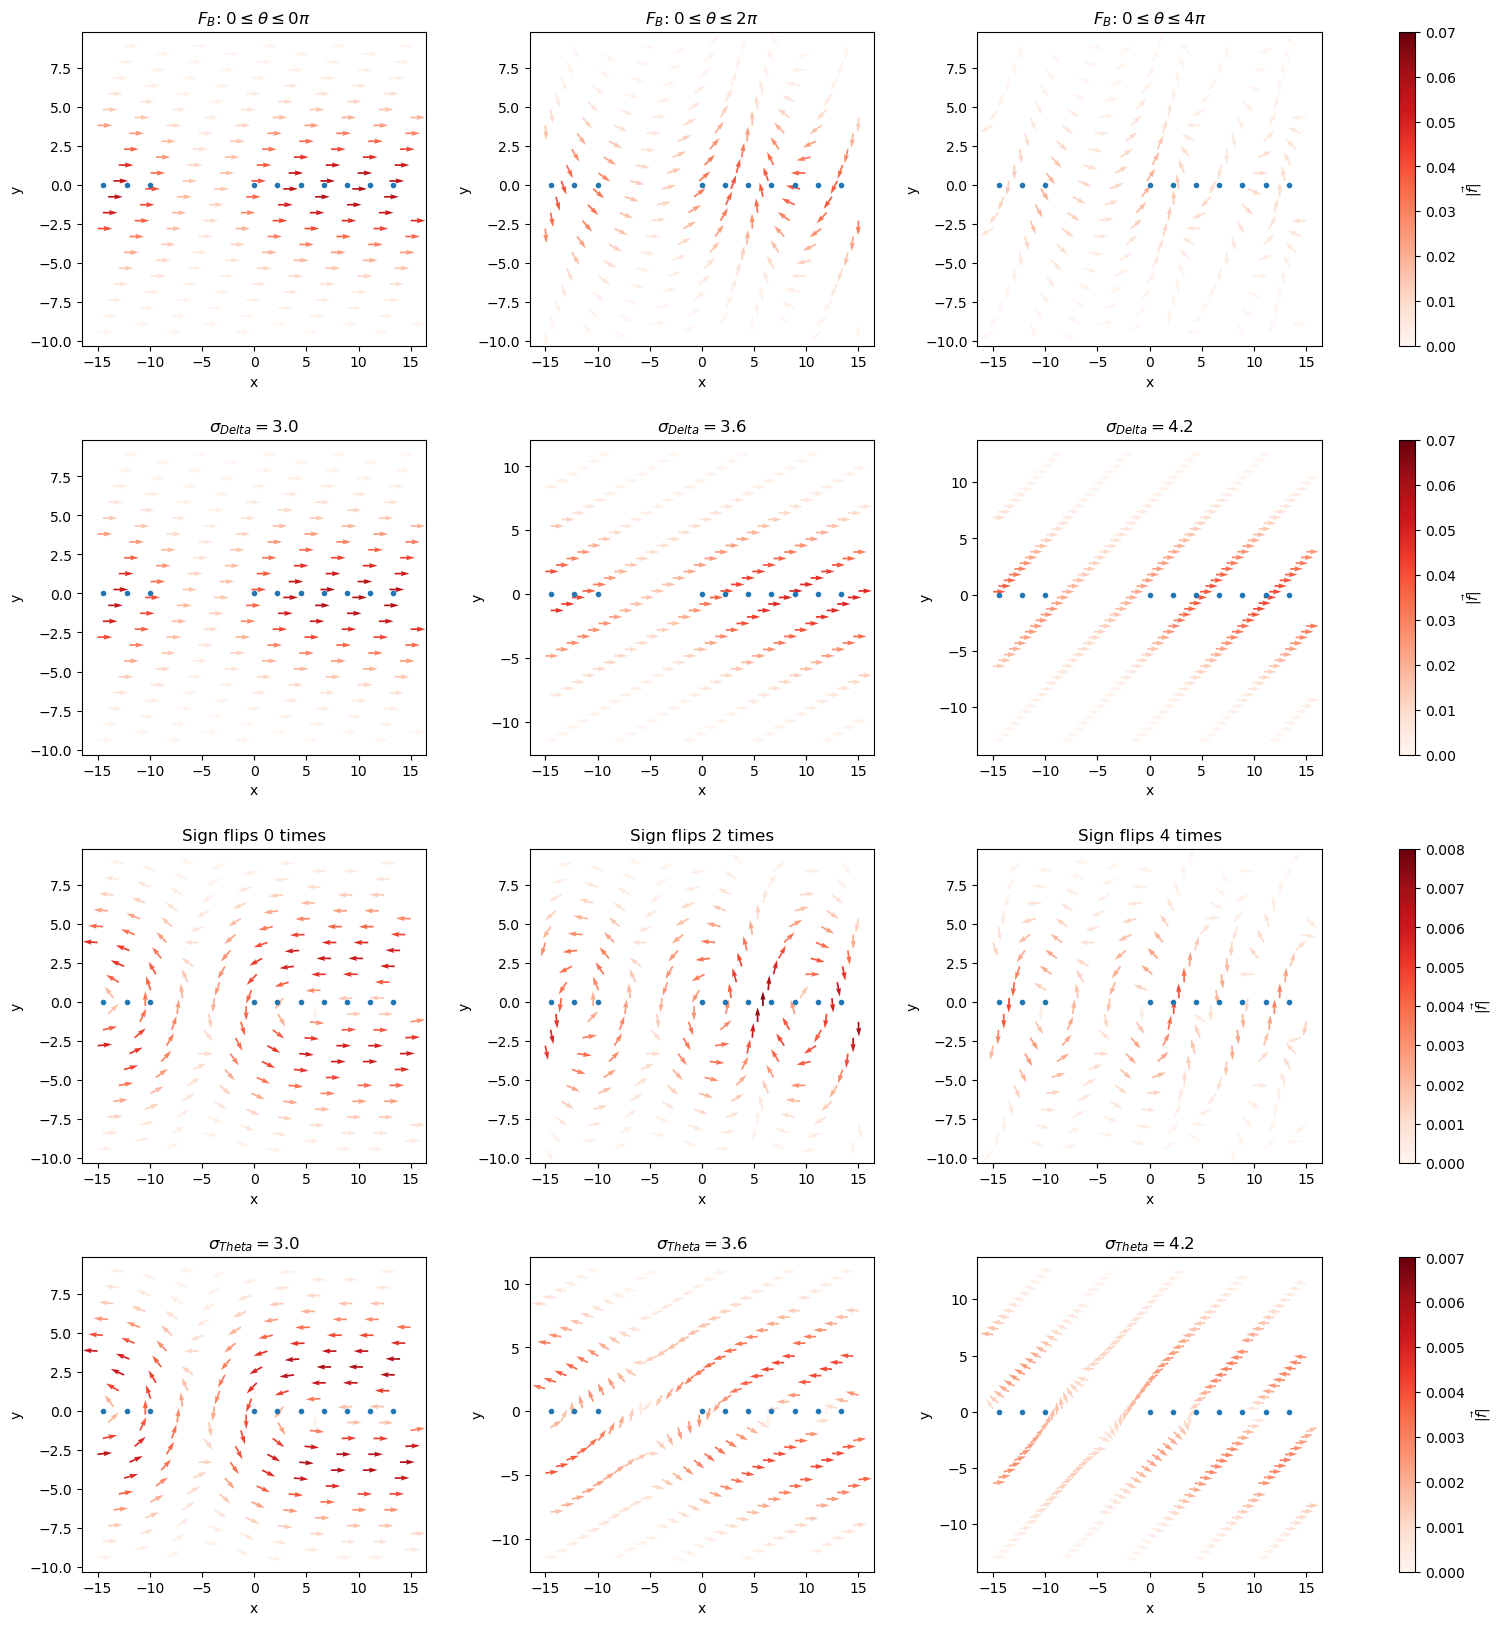

In [15]:
# Check fcm_spread function
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
quiver_step = 13
mag_threshold = 1e-8

# Different F_seg
T_seg = np.zeros(10)
x = np.linspace(0, 20, 10)
y = np.zeros(10)
L_x = L_y = 30
N_x = N_y = 60
x[x >= L_x*0.5] -= L_x
x[x < -L_x*0.5] += L_x
y[y >= L_y*0.5] -= L_y
y[y < -L_y*0.5] += L_y
s = np.vstack([x, y]).T
sigma_Delta = sigma_Theta = 3
for i in range(3):
    F_B = np.zeros((10, 2))
    gen_f = i*np.linspace(0, 2*np.pi, 10)
    F_B[:, 0] = np.cos(gen_f)
    F_B[:, 1] = np.sin(gen_f)
    f = cp.asnumpy(fcm_spread(F_B, T_seg, s, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta))
    grid_x = np.linspace(-0.5*L_x, 0.5*L_x, N_x)
    grid_y = np.linspace(-0.5*L_y, 0.5*L_y, N_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y, indexing='ij')
    mag = np.sqrt(f[...,0]**2+f[...,1]**2)
    mask = mag > mag_threshold
    f_hat_x = f[...,0][mask] / mag[mask]
    f_hat_y = f[...,1][mask] / mag[mask]
    Q = ax[0, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    f_hat_x[::quiver_step], f_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.07),
    )
    ax[0, i].plot(x, y, '.')
    ax[0, i].set_title(r"$F_B$:"+f" $0 \\leq \\theta \\leq {(2*i)}\\pi$")
    ax[0, i].set_xlabel('x')
    ax[0, i].set_ylabel('y')
plt.colorbar(Q, ax=ax[0, :], label=r'$|\vec{f}|$')

# Different sigma_Delta
T_seg = np.zeros(10)
x = np.linspace(0, 20, 10)
y = np.zeros(10)
L_x = L_y = 30
N_x = N_y = 60
x[x >= L_x*0.5] -= L_x
x[x < -L_x*0.5] += L_x
y[y >= L_y*0.5] -= L_y
y[y < -L_y*0.5] += L_y
s = np.vstack([x, y]).T
sigma_Theta = 3
F_B = np.zeros((10, 2))
F_B[:, 0] = 1
for i in range(3):
    sigma_Delta = 3 + i*0.6
    f = cp.asnumpy(fcm_spread(F_B, T_seg, s, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta))
    grid_x = np.linspace(-0.5*L_x, 0.5*L_x, N_x)
    grid_y = np.linspace(-0.5*L_y, 0.5*L_y, N_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y, indexing='ij')
    mag = np.sqrt(f[...,0]**2+f[...,1]**2)
    mask = mag > mag_threshold
    f_hat_x = f[...,0][mask] / mag[mask]
    f_hat_y = f[...,1][mask] / mag[mask]
    Q = ax[1, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    f_hat_x[::quiver_step], f_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.07),
    )
    ax[1, i].plot(x, y, '.')
    ax[1, i].set_title(r"$\sigma_{Delta}=$"+f"{sigma_Delta:.1f}")
    ax[1, i].set_xlabel('x')
    ax[1, i].set_ylabel('y')
fig.colorbar(Q, ax=ax[1, :], label=r'$|\vec{f}|$')

# Different T_E
x = np.linspace(0, 20, 10)
y = np.zeros(10)
L_x = L_y = 30
N_x = N_y = 60
x[x >= L_x*0.5] -= L_x
x[x < -L_x*0.5] += L_x
y[y >= L_y*0.5] -= L_y
y[y < -L_y*0.5] += L_y
s = np.vstack([x, y]).T
sigma_Delta = sigma_Theta = 3
F_seg = np.zeros((10, 2))
for i in range(3):
    gen_t = i*np.linspace(0, 2*np.pi, 10)
    T_E = np.sign(np.cos(gen_t))
    f = cp.asnumpy(fcm_spread(F_seg, T_E, s, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta))
    grid_x = np.linspace(-0.5*L_x, 0.5*L_x, N_x)
    grid_y = np.linspace(-0.5*L_y, 0.5*L_y, N_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y, indexing='ij')
    mag = np.sqrt(f[...,0]**2+f[...,1]**2)
    mask = mag > mag_threshold
    f_hat_x = f[...,0][mask] / mag[mask]
    f_hat_y = f[...,1][mask] / mag[mask]
    Q = ax[2, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    f_hat_x[::quiver_step], f_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.008)
    )
    ax[2, i].plot(x, y, '.')
    ax[2, i].set_title(f"Sign flips {2*i} times")
    ax[2, i].set_xlabel('x')
    ax[2, i].set_ylabel('y')
fig.colorbar(Q, ax=ax[2, :], label=r'$|\vec{f}|$')

# Different sigma_Theta
x = np.linspace(0, 20, 10)
y = np.zeros(10)
L_x = L_y = 30
N_x = N_y = 60
x[x >= L_x*0.5] -= L_x
x[x < -L_x*0.5] += L_x
y[y >= L_y*0.5] -= L_y
y[y < -L_y*0.5] += L_y
s = np.vstack([x, y]).T
sigma_Delta = 3
F_B = np.zeros((10, 2))
T_E = np.ones(10)
for i in range(3):
    sigma_Theta = 3 + i*0.6
    f = cp.asnumpy(fcm_spread(F_B, T_E, s, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta))
    grid_x = np.linspace(-0.5*L_x, 0.5*L_x, N_x)
    grid_y = np.linspace(-0.5*L_y, 0.5*L_y, N_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y, indexing='ij')
    mag = np.sqrt(f[...,0]**2+f[...,1]**2)
    mask = mag > mag_threshold
    f_hat_x = f[...,0][mask] / mag[mask]
    f_hat_y = f[...,1][mask] / mag[mask]
    Q = ax[3, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    f_hat_x[::quiver_step], f_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.007)
    )
    ax[3, i].plot(x, y, '.')
    ax[3, i].set_title(r"$\sigma_{Theta}=$"+f"{sigma_Theta:.1f}")
    ax[3, i].set_xlabel('x')
    ax[3, i].set_ylabel('y')
fig.colorbar(Q, ax=ax[3, :], label=r'$|\vec{f}|$')

plt.show()

In [16]:
def solve_stokes(f_gpu, L_x, L_y, eta):
    """
    GPU‐accelerated Stokes solver via FCM/FFT on a periodic 2D box.

    Parameters
    ----------
    f_gpu : cupy.ndarray, shape (N_x, N_y, 2)
        The (x,y) force‐density on the uniform grid.
    L_x, L_y : floats
        Domain sizes in x and y (periodic box).
    eta : float
        Viscosity of the fluid.

    Returns
    -------
    u_x, u_y : cupy.ndarray
        The real‐space velocity on the same (N_x x N_y) grid.
    """
    # 1) Split x- amd y-components
    f_x_gpu = f_gpu[..., 0]
    f_y_gpu = f_gpu[..., 1]

    # 2) Grid dimensions
    N_x, N_y = f_x_gpu.shape

    # 3) Build/cache  k_x, k_y, and inv_k2 on GPU.  Keyed on (N_x,N_y,L_x,L_y).
    #    We attach them to the function object as solve_stokes._gpu_cache
    cache_key = (N_x, N_y, L_x, L_y)
    if not hasattr(solve_stokes, "_gpu_cache"):
        solve_stokes._gpu_cache = {}
    if cache_key not in solve_stokes._gpu_cache:
        # 3a) Build 1D frequency vectors (on CPU), then move to GPU
        #     np.fft.fftfreq(N) returns [0,  1/N,  2/N, …,  -(1/N), …]
        kx_1d_gpu = (2 * cp.pi * N_x / L_x) * cp.fft.fftfreq(N_x)  # length N_x on CPU
        ky_1d_gpu = (2 * cp.pi * N_y / L_y) * cp.fft.fftfreq(N_y)  # length N_y on CPU

        # 3b) Make 2D mesh of k_x, k_y on GPU
        k_x_gpu, k_y_gpu = cp.meshgrid(kx_1d_gpu, ky_1d_gpu, indexing='ij')  # shape (N_x, N_y)

        # 3c) Compute squared magnitude and its reciprocal (inv_k2)
        k2_gpu = (k_x_gpu**2 + k_y_gpu**2).astype(cp.float64)
        inv_k2_gpu = cp.zeros_like(k2_gpu)
        nonzero = k2_gpu > 1e-16
        inv_k2_gpu[nonzero] = 1.0 / k2_gpu[nonzero]

        # 3d) Cache them
        solve_stokes._gpu_cache[cache_key] = (k_x_gpu, k_y_gpu, inv_k2_gpu)

    # 4) Retrieve from cache
    else:
        k_x_gpu, k_y_gpu, inv_k2_gpu = solve_stokes._gpu_cache[cache_key]

    # 5) Forward FFT of the two force components (on GPU)
    fhat_x = cp.fft.fft2(f_x_gpu)
    fhat_y = cp.fft.fft2(f_y_gpu)

    # 6) Compute k·\hat{k} in Fourier space:
    #    shape (N_x, N_y), complex
    k_dot_fhat = (k_x_gpu * fhat_x) + (k_y_gpu * fhat_y)

    # 7) Build \hat{u}_x, \hat{u}_y via projection and division by (eta |k|^2):
    #    \hat{u}_x = [ fhat_x − k_x (k·\hat{f})/|k|^2 ] / (eta |k|^2),
    #    \hat{u}_y = [ fhat_y − k_y (k·\hat{f})/|k|^2 ] / (eta |k|^2).
    #
    #    Because inv_k2_gpu[0,0] = 0, the (0,0) mode is automatically set to zero.
    factor = inv_k2_gpu / eta             # (N_x, N_y) real
    temp = k_dot_fhat * inv_k2_gpu        # (k·\hat{f})/|k|^2, zero at (0,0)
    uhat_x = (fhat_x - k_x_gpu * temp) * factor
    uhat_y = (fhat_y - k_y_gpu * temp) * factor

    # 8) Inverse FFT → real space (on GPU), then drop any tiny imaginary bits
    u_x = cp.real(cp.fft.ifft2(uhat_x))
    u_y = cp.real(cp.fft.ifft2(uhat_y))

    return u_x, u_y

C:\Users\e0028670\.conda\envs\sperm_env\Lib\site-packages\matplotlib\quiver.py:678: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
C:\Users\e0028670\.conda\envs\sperm_env\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


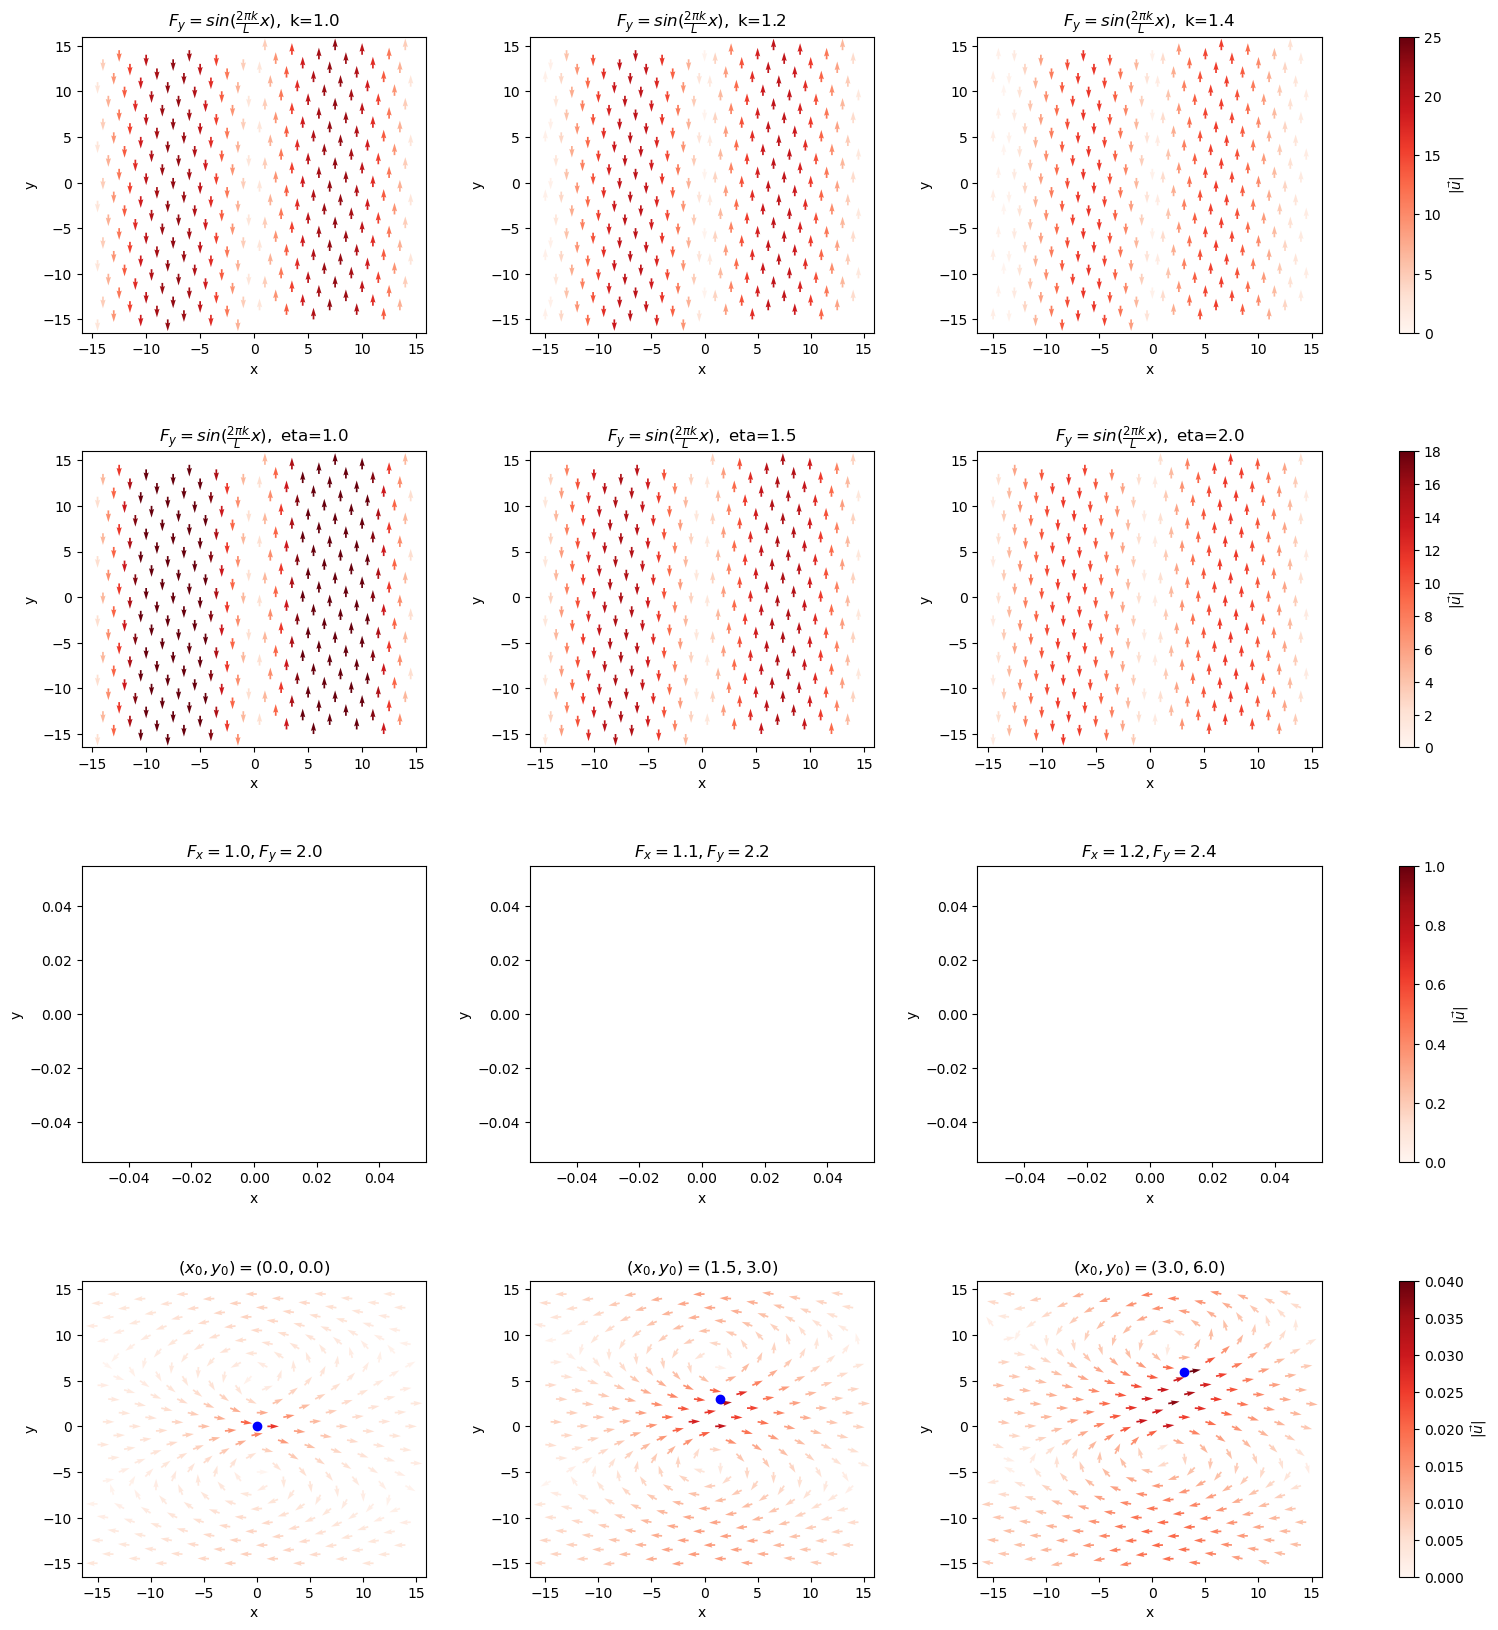

In [17]:
# Check solve_stokes function
fig, ax = plt.subplots(4, 3, figsize=(20,20))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
quiver_step = 13
mag_threshold = 1e-7

# Sinusoidal force with varying k_x, constant eta
eta = 1
L_x = L_y = 30
x = np.linspace(-L_x/2, L_x/2, 60, endpoint=False)
y = np.linspace(-L_y/2, L_y/2, 60, endpoint=False)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((60, 60, 2))
for i in range(3):
    f[..., 1] = np.sin(2*np.pi*(1+0.2*i)*grid_x/L_x)
    u_x, u_y = solve_stokes(cp.asarray(f), L_x, L_y, eta)
    u_x = cp.asnumpy(u_x)
    u_y = cp.asnumpy(u_y)
    mag = np.sqrt(u_x**2+u_y**2)
    mask = mag > mag_threshold
    u_hat_x = u_x[mask] / mag[mask]
    u_hat_y = u_y[mask] / mag[mask]
    Q = ax[0, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    u_hat_x[::quiver_step], u_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 25),
    )
    ax[0, i].set_title(r"$F_y = sin (\frac{2 \pi k}{L}x), $"+f" k={1+0.2*i:.1f}")
    ax[0, i].set_xlabel('x')
    ax[0, i].set_ylabel('y')
plt.colorbar(Q, ax=ax[0, :], label=r'$|\vec{u}|$')

# Sinusoidal force with constant k_x, varying eta
L_x = L_y = 30
x = np.linspace(-L_x/2, L_x/2, 60, endpoint=False)
y = np.linspace(-L_y/2, L_y/2, 60, endpoint=False)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((60, 60, 2))
f[..., 1] = np.sin(2*np.pi*(1)*grid_x/L_x)
for i in range(3):
    eta = 1 + 0.5*i
    u_x, u_y = solve_stokes(cp.asarray(f), L_x, L_y, eta)
    u_x = cp.asnumpy(u_x)
    u_y = cp.asnumpy(u_y)
    mag = np.sqrt(u_x**2+u_y**2)
    mask = mag > mag_threshold
    u_hat_x = u_x[mask] / mag[mask]
    u_hat_y = u_y[mask] / mag[mask]
    Q = ax[1, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    u_hat_x[::quiver_step], u_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 18),
    )
    ax[1, i].set_title(r"$F_y = sin (\frac{2 \pi k}{L}x), $"+f" eta={eta}")
    ax[1, i].set_xlabel('x')
    ax[1, i].set_ylabel('y')
plt.colorbar(Q, ax=ax[1, :], label=r'$|\vec{u}|$')

# Constant force of increasing magnitude
L_x = L_y = 30
x = np.linspace(-L_x/2, L_x/2, 60, endpoint=False)
y = np.linspace(-L_y/2, L_y/2, 60, endpoint=False)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((60, 60, 2))
for i in range(3):
    fx = 1+0.1*i
    fy = 2+0.2*i
    f[..., 0] = fx
    f[..., 1] = fy
    u_x, u_y = solve_stokes(cp.asarray(f), L_x, L_y, eta)
    u_x = cp.asnumpy(u_x)
    u_y = cp.asnumpy(u_y)
    mag = np.sqrt(u_x**2+u_y**2)
    mask = mag > mag_threshold
    u_hat_x = u_x[mask] / mag[mask]
    u_hat_y = u_y[mask] / mag[mask]
    Q = ax[2, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    u_hat_x[::quiver_step], u_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 1),
    )
    ax[2, i].set_title(f"$F_x={fx}, F_y={fy}$")
    ax[2, i].set_xlabel('x')
    ax[2, i].set_ylabel('y')
plt.colorbar(Q, ax=ax[2, :], label=r'$|\vec{u}|$')

# Point force at different source points
L_x = L_y = 30
x = np.linspace(-L_x/2, L_x/2, 60, endpoint=False)
y = np.linspace(-L_y/2, L_y/2, 60, endpoint=False)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((60, 60, 2))
for i in range(3):
    x_pos = 30+3*i
    y_pos = 30+6*i
    f[x_pos, y_pos, 0] = 1
    u_x, u_y = solve_stokes(cp.asarray(f), L_x, L_y, eta)
    u_x = cp.asnumpy(u_x)
    u_y = cp.asnumpy(u_y)
    mag = np.sqrt(u_x**2+u_y**2)
    mask = mag > mag_threshold
    u_hat_x = u_x[mask] / mag[mask]
    u_hat_y = u_y[mask] / mag[mask]
    Q = ax[3, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    u_hat_x[::quiver_step], u_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.04),
    )
    ax[3, i].set_title(f"$(x_0, y_0) = ({x[x_pos]}, {y[y_pos]})$")
    ax[3, i].set_xlabel('x')
    ax[3, i].set_ylabel('y')
    ax[3, i].plot(x[x_pos], y[y_pos], 'bo')
plt.colorbar(Q, ax=ax[3, :], label=r'$|\vec{u}|$')

plt.show()

In [18]:
def segment_velocities(u_x, u_y, Lx, Ly, seg_pos, a, b, sigma_D, sigma_T):
    """
    Compute linear and angular velocities of each filament segment from a 2D fluid velocity field,
    using convolution with Gaussian kernels Delta and Theta.

    Parameters
    ----------
    u_x, u_y : cupy.ndarrays, shape (N_x, N_y)
        The fluid velocity components on a uniform, periodic 2D grid.
    Lx, Ly : floats
        Domain sizes in x and y (periodic box). 
    seg_pos : numpy.ndarray, shape (N_seg, 2)
        Array of (x_n, y_n) positions for the midpoint of each of the N_seg segments, including head.
    a, b : floats
        Head and flagellum radii respectively.
    sigma_D, sigma_T : floats
        Gaussian envelope size for Delta and Theta respectively

    Returns
    -------
    V_seg : cupy.ndarray, shape (N_seg, 2)
        Linear velocities of each segment (V_x, V_y).
    Omega_seg : cupy.ndarray, shape (N_seg, )
        Scalar (out‐of‐plane) angular velocity of each segment.
    """

   # Sanity check for NaNs
    if cp.isnan(u_x).any().item() or cp.isnan(u_y).any().item():
        raise ValueError("segment_velocities: input velocity field u_x or u_y contains NaNs!")
    
    Nx, Ny = u_x.shape
    dx, dy = Lx/Nx, Ly/Ny
    # 1) curl via periodic roll for all interior points
    dux_dy = (cp.roll(u_x,-1,axis=1)-cp.roll(u_x,1,axis=1))/(2*dy)
    duy_dx = (cp.roll(u_y,-1,axis=0)-cp.roll(u_y,1,axis=0))/(2*dx)

    # for edge points
    dux_dy[:, 0] = (u_x[:, 1] - u_x[:, 0])/dy
    dux_dy[:, -1] = (u_x[:, -1] - u_x[:, -2])/dy
    duy_dx[0] = (u_y[1] - u_y[0])/dx
    duy_dx[-1] = (u_y[-1] - u_y[-2])/dx
    
    curl = duy_dx - dux_dy

    # 2) get FFTs of kernels
    if not hasattr(segment_velocities, "_kernel_cache"):
        segment_velocities._kernel_cache = {}

    def _get_periodic_kernel(Nx, Ny, dx, sigma):
        key = (Nx, Ny, dx, sigma)
        if key not in segment_velocities._kernel_cache:
            # small stencil in physical coords
            k = int(6*sigma/dx) + (int(6*sigma/dx)%2==0)
            grid = cp.linspace(-3*sigma, 3*sigma, k)
            Xs, Ys = cp.meshgrid(grid, grid, indexing='ij')
            Gsmall = cp.exp(-(Xs**2+Ys**2)/(2*sigma**2)) / (2*cp.pi*sigma**2)
    
            # embed in full grid & shift
            Gfull = cp.zeros((Nx, Ny), dtype=float)
            sx = (Nx - k)//2; sy = (Ny - k)//2
            Gfull[sx:sx+k, sy:sy+k] = Gsmall
            Gfull = cp.fft.ifftshift(Gfull)       # move peak → index 0,0
    
            segment_velocities._kernel_cache[key] = cp.fft.rfftn(Gfull)  # cache real‐FFT
        return segment_velocities._kernel_cache[key]
    
    Ghat_D = _get_periodic_kernel(Nx,Ny,dx,sigma_D)
    Ghat_T = _get_periodic_kernel(Nx,Ny,dx,sigma_T)

    # 3) FFT your fields
    Fx = cp.fft.rfftn(u_x)
    Fy = cp.fft.rfftn(u_y)
    Fc = cp.fft.rfftn(curl)

    # 4) multiply & ifft → circular conv
    conv_Vx = cp.fft.irfftn(Fx * Ghat_D, s=(Nx,Ny)) * (dx*dy)
    conv_Vy = cp.fft.irfftn(Fy * Ghat_D, s=(Nx,Ny)) * (dx*dy)
    conv_c  = cp.fft.irfftn(Fc * Ghat_T, s=(Nx,Ny)) * (dx*dy)

    # Move data to GPU
    seg_pos = cp.asarray(seg_pos)
    
    # 5) sample at segment positions (modulo Nx,Ny)
    ix = cp.mod(cp.rint((seg_pos[:,0]+0.5*Lx)/dx).astype(int),Nx)
    iy = cp.mod(cp.rint((seg_pos[:,1]+0.5*Ly)/dy).astype(int),Ny)

    V_seg     = cp.vstack((conv_Vx[ix,iy], conv_Vy[ix,iy])).T
    Omega_seg = 0.5 * conv_c[ix,iy]

    return V_seg, Omega_seg

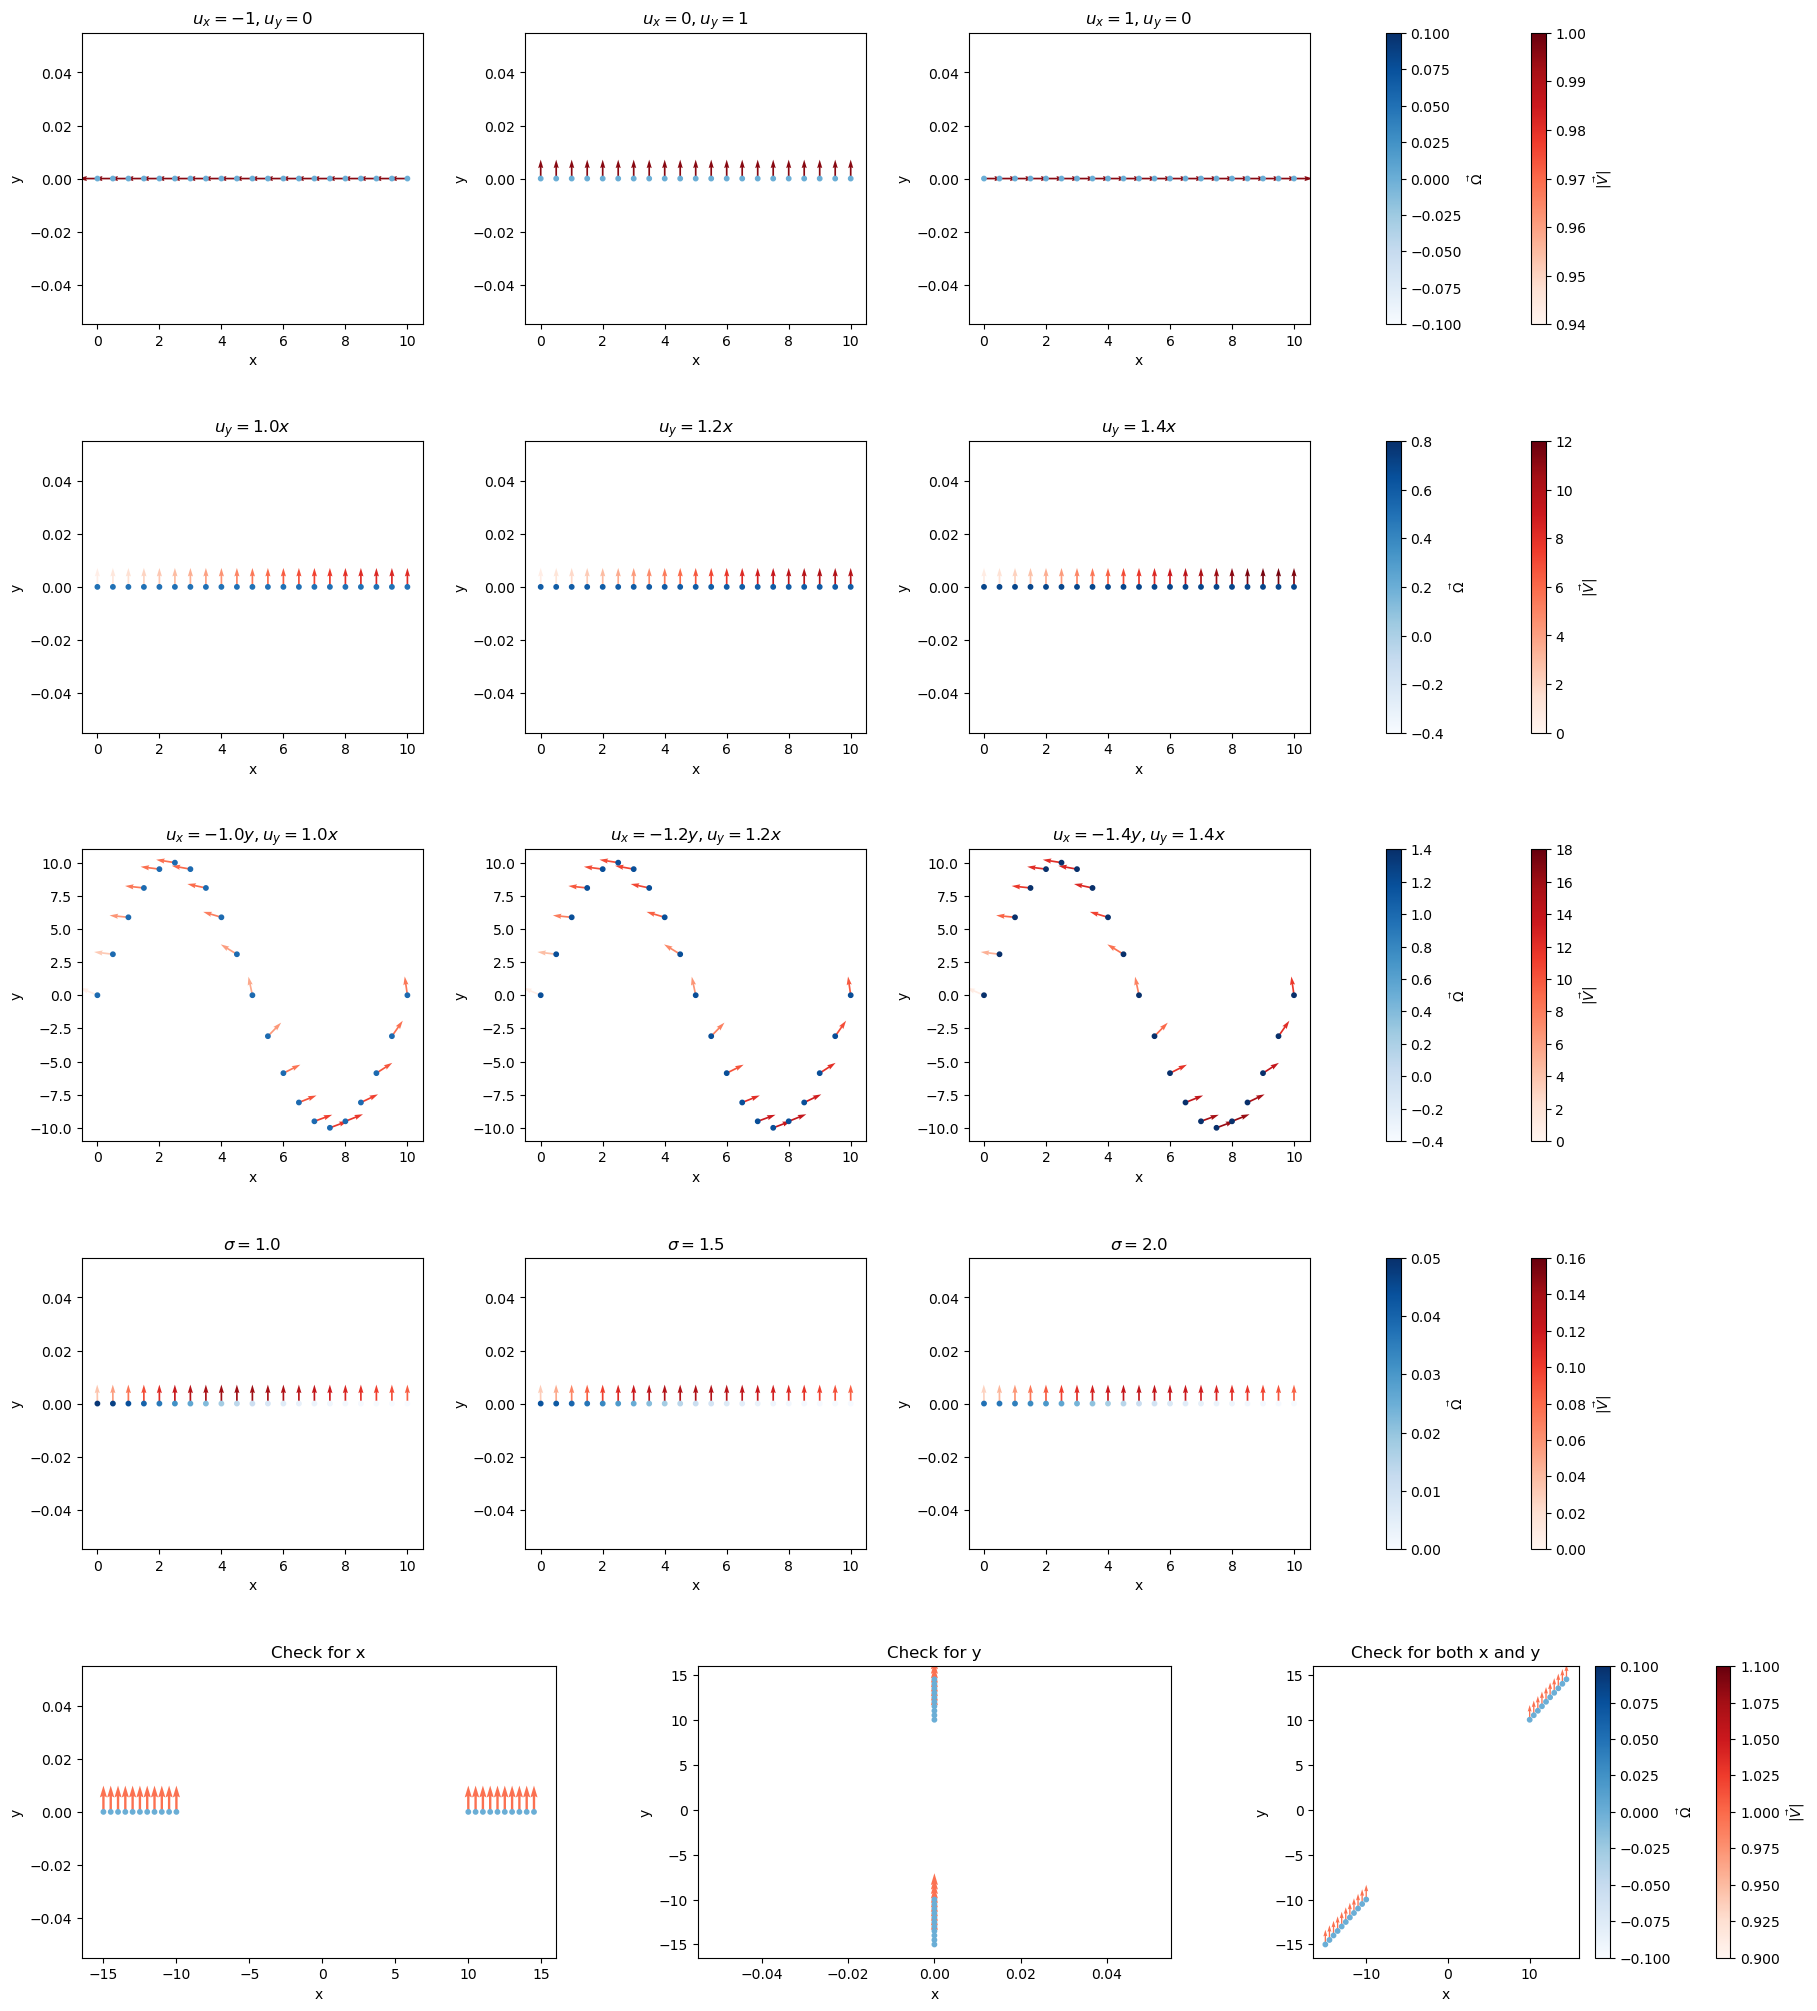

In [19]:
# Check segment_velocities function
fig, ax = plt.subplots(5, 3, figsize=(22, 25))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
quiver_step = 1
mag_threshold = 1e-5

# Uniform fluid flow of varying direction
L_x = L_y = 30
segment_positions = np.zeros((21, 2))
segment_positions[:, 0] = np.linspace(0, 10, 21)
a = 3
b = 1
sigma_D = sigma_T = 3
for i in range(3):
    u_x = (i-1)*cp.ones((60, 60))
    u_y = (i%2)*cp.ones((60, 60))
    V_seg, Omega_seg = segment_velocities(u_x, u_y, L_x, L_y, segment_positions, a, b, sigma_D, sigma_T)
    V_seg = cp.asnumpy(V_seg)
    Omega_seg = cp.asnumpy(Omega_seg)
    mag = np.sqrt(V_seg[:, 0]**2+V_seg[:, 1]**2)
    mask = mag > mag_threshold
    V_hat_x = V_seg[:, 0][mask] / mag[mask]
    V_hat_y = V_seg[:, 1][mask] / mag[mask]
    Q = ax[0, i].quiver(
    segment_positions[:, 0][mask][::quiver_step], segment_positions[:, 1][mask][::quiver_step],        # origins
    V_hat_x[::quiver_step], V_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0.94, 1.0),
    )
    ax[0, i].set_title(f"$u_x={i-1}, u_y={i%2}$")
    ax[0, i].set_xlabel('x')
    ax[0, i].set_ylabel('y')
    S = ax[0, i].scatter(
    segment_positions[:, 0], segment_positions[:, 1],
    c=Omega_seg,
    s=10,
    cmap='Blues',
    clim=(-0.1, 0.1))
plt.colorbar(Q, ax=ax[0, :], label=r'$|\vec{V}|$', pad=-0.05)
plt.colorbar(S, ax=ax[0, :], label=r'$\vec{\Omega}$', pad=0.05)

# Pure shear of varying magnitude
L_x = L_y = 30
X, Y = cp.meshgrid(cp.linspace(-L_x/2, L_x/2, 60, endpoint=False), cp.linspace(-L_y/2, L_y/2, 60, endpoint=False), indexing='ij')
segment_positions = np.zeros((21, 2))
segment_positions[:, 0] = np.linspace(0, 10, 21)
a = 3
b = 1
sigma_D = sigma_T = 3
u_x = cp.zeros((60, 60))
for i in range(3):
    S = 1+0.2*i
    u_y = S*X
    V_seg, Omega_seg = segment_velocities(u_x, u_y, L_x, L_y, segment_positions, a, b, sigma_D, sigma_T)
    V_seg = cp.asnumpy(V_seg)
    Omega_seg = cp.asnumpy(Omega_seg)
    mag = np.sqrt(V_seg[:, 0]**2+V_seg[:, 1]**2)
    mask = mag > mag_threshold
    V_hat_x = V_seg[:, 0][mask] / mag[mask]
    V_hat_y = V_seg[:, 1][mask] / mag[mask]
    Q = ax[1, i].quiver(
    segment_positions[:, 0][mask][::quiver_step], segment_positions[:, 1][mask][::quiver_step],        # origins
    V_hat_x[::quiver_step], V_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 12),
    )
    ax[1, i].set_title(f"$u_y={S}x$")
    ax[1, i].set_xlabel('x')
    ax[1, i].set_ylabel('y')
    S = ax[1, i].scatter(
    segment_positions[:, 0], segment_positions[:, 1],
    c=Omega_seg,
    s=10,
    cmap='Blues',
    clim=(-0.4, 0.8)
    )
plt.colorbar(Q, ax=ax[1, :], label=r'$|\vec{V}|$', pad=-0.05)
plt.colorbar(S, ax=ax[1, :], label=r'$\vec{\Omega}$', pad=0.05)

# Pure rotation of varying magnitude
L_x = L_y = 30
X, Y = cp.meshgrid(cp.linspace(-L_x/2, L_x/2, 60, endpoint=False), cp.linspace(-L_y/2, L_y/2, 60, endpoint=False), indexing='ij')
segment_positions = np.zeros((21, 2))
segment_positions[:, 0] = np.linspace(0, 10, 21)
segment_positions[:, 1] = 10*np.sin(np.pi*np.linspace(0, 10, 21)/5)
a = 3
b = 1
sigma_D = sigma_T = 3
for i in range(3):
    omega = 1+0.2*i
    u_x = -omega*Y
    u_y = omega*X
    V_seg, Omega_seg = segment_velocities(u_x, u_y, L_x, L_y, segment_positions, a, b, sigma_D, sigma_T)
    V_seg = cp.asnumpy(V_seg)
    Omega_seg = cp.asnumpy(Omega_seg)
    mag = np.sqrt(V_seg[:, 0]**2+V_seg[:, 1]**2)
    mask = mag > mag_threshold
    V_hat_x = V_seg[:, 0][mask] / mag[mask]
    V_hat_y = V_seg[:, 1][mask] / mag[mask]
    Q = ax[2, i].quiver(
    segment_positions[:, 0][mask][::quiver_step], segment_positions[:, 1][mask][::quiver_step],        # origins
    V_hat_x[::quiver_step], V_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 18),
    )
    ax[2, i].set_title(f"$u_x=-{omega}y, u_y={omega}x$")
    ax[2, i].set_xlabel('x')
    ax[2, i].set_ylabel('y')
    S = ax[2, i].scatter(
    segment_positions[:, 0], segment_positions[:, 1],
    c=Omega_seg,
    s=10,
    cmap='Blues',
    clim=(-0.4, 1.4)
    )
plt.colorbar(Q, ax=ax[2, :], label=r'$|\vec{V}|$', pad=-0.05)
plt.colorbar(S, ax=ax[2, :], label=r'$\vec{\Omega}$', pad=0.05)

# Single Gaussian vortex of varying spread
L_x = L_y = 30
X, Y = cp.meshgrid(cp.linspace(-L_x/2, L_x/2, 60, endpoint=False), cp.linspace(-L_y/2, L_y/2, 60, endpoint=False), indexing='ij')
r2 = X*X + Y*Y
segment_positions = np.zeros((21, 2))
segment_positions[:, 0] = np.linspace(0, 10, 21)
a = 3
b = 1
sigma_D = sigma_T = 3
u_x = cp.zeros_like(r2)
u_y = cp.zeros_like(r2)
for i in range(3):
    sigma = 1+0.5*i
    u_x = -Y*(1-cp.exp(-r2/(2*sigma**2)))/r2
    u_y = X*(1-cp.exp(-r2/(2*sigma**2)))/r2
    u_x = cp.nan_to_num(u_x, nan=0.0)
    u_y = cp.nan_to_num(u_y, nan=0.0)
    V_seg, Omega_seg = segment_velocities(u_x, u_y, L_x, L_y, segment_positions, a, b, sigma_D, sigma_T)
    V_seg = cp.asnumpy(V_seg)
    Omega_seg = cp.asnumpy(Omega_seg)
    mag = np.sqrt(V_seg[:, 0]**2+V_seg[:, 1]**2)
    mask = mag > mag_threshold
    V_hat_x = V_seg[:, 0][mask] / mag[mask]
    V_hat_y = V_seg[:, 1][mask] / mag[mask]
    Q = ax[3, i].quiver(
    segment_positions[:, 0][mask][::quiver_step], segment_positions[:, 1][mask][::quiver_step],        # origins
    V_hat_x[::quiver_step], V_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.16),
    )
    ax[3, i].set_title(f"$\\sigma={sigma}$")
    ax[3, i].set_xlabel('x')
    ax[3, i].set_ylabel('y')
    S = ax[3, i].scatter(
    segment_positions[:, 0], segment_positions[:, 1],
    c=Omega_seg,
    s=10,
    cmap='Blues',
    clim=(0, 0.05)
    )
plt.colorbar(Q, ax=ax[3, :], label=r'$|\vec{V}|$', pad=-0.05)
plt.colorbar(S, ax=ax[3, :], label=r'$\vec{\Omega}$', pad=0.05)

# Periodicity check
L_x = L_y = 30
X, Y = cp.meshgrid(cp.linspace(-L_x/2, L_x/2, 60, endpoint=False), cp.linspace(-L_y/2, L_y/2, 60, endpoint=False), indexing='ij')
r2 = X*X + Y*Y
a = 3
b = 1
sigma_D = sigma_T = 3
u_x = cp.zeros_like(r2)
u_y = cp.ones_like(r2)
title_list = ['Check for x', 'Check for y', 'Check for both x and y']
for i in range(3):
    segment_positions = np.zeros((21, 2))
    if i%2==0:
        segment_positions[:, 0] = np.linspace(10, 20, 21)
    if i>0:
        segment_positions[:, 1] = np.linspace(10, 20, 21)
    segment_positions = sperm_coordinates_pbc(segment_positions)
    V_seg, Omega_seg = segment_velocities(u_x, u_y, L_x, L_y, segment_positions, a, b, sigma_D, sigma_T)
    V_seg = cp.asnumpy(V_seg)
    Omega_seg = cp.asnumpy(Omega_seg)
    mag = np.sqrt(V_seg[:, 0]**2+V_seg[:, 1]**2)
    mask = mag > mag_threshold
    V_hat_x = V_seg[:, 0][mask] / mag[mask]
    V_hat_y = V_seg[:, 1][mask] / mag[mask]
    Q = ax[4, i].quiver(
    segment_positions[:, 0][mask][::quiver_step], segment_positions[:, 1][mask][::quiver_step],        # origins
    V_hat_x[::quiver_step], V_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0.9, 1.1),
    )
    ax[4, i].set_title(f"{title_list[i]}")
    ax[4, i].set_xlabel('x')
    ax[4, i].set_ylabel('y')
    S = ax[4, i].scatter(
    segment_positions[:, 0], segment_positions[:, 1],
    c=Omega_seg,
    s=10,
    cmap='Blues',
    clim=(-0.1, 0.1)
    )
plt.colorbar(Q, ax=ax[4, i], label=r'$|\vec{V}|$', pad=0.15)
plt.colorbar(S, ax=ax[4, i], label=r'$\vec{\Omega}$', pad=0.05)

plt.show()

In [20]:
def pack_state(Y1, thetas, Lambdas):
    """
    Pack the degrees of freedom into a 1D vector X.
    
    Parameters
    ----------
    Y1 : array-like, shape (2,)
        Head‐segment midpoint position [x, y].
    thetas : array-like, shape (N_flag+1,)
        Tangent angles at each segment midpoint, head inclusive.
    Lambdas : array-like, shape (N_flag+2, 2)
        Constraint multipliers at each segment edge.

    Returns
    -------
    X : ndarray, shape (2 + (N_flag+1) + 2*N_flag,)
        The packed state vector.
    """
    return np.hstack([Y1, thetas, Lambdas[1:-1].ravel()])

In [21]:
def unpack_state(X, N_flag):
    """
    Unpack the solver state vector X into (Y1, thetas, Lambdas).

    Parameters
    ----------
    X : array-like, shape (2 + (N_flag+1) + 2*N_flag,)
        The packed state vector.
    N_flag : int
        Number of flagellum segments (so there are N_flag+1 midpoints
        and N_flag+2 edges).

    Returns
    -------
    Y1 : ndarray, shape (2,)
        Head‐segment midpoint position.
    thetas : ndarray, shape (N_flag+1,)
        Tangent angles at each segment midpoint.
    Lambdas : ndarray, shape (N_flag+2, 2)
        Constraint multipliers at each segment edge.
    """
    Y1 = X[:2]
    thetas = X[2:3+N_flag]
    Lambda_boundary = np.zeros((1, 2))
    Lambdas = np.concatenate([Lambda_boundary, X[3+N_flag:].reshape(N_flag,2), Lambda_boundary])
    return Y1, thetas, Lambdas

In [22]:
def compute_segment_forces_and_torques(
    sperm,     
    Y,         
    theta,     
    Lambda,    
    t,         
    F_S,       
    chi        
):
    """
    Compute total segment forces and torques.

    Parameters
    ----------
    sperm: instance of Sperm2D class
    Y: ndarray, shape (N_flag+1, 2)
        segment midpoints
    theta: ndarray, shape (N_flag+1, )
        segment angles
    Lambda: ndarray, shape (N_flag+2, 2)
        constraint multipliers
    t, F_S, chi: floats
        current time, steric strength, and steric range factor respectively
    
    Returns
    -------
      F_seg: ndarray, shape (N_flag+1,2):
          total force on each segment midpoint
      T_seg: ndarray, shape (N_flag+1,):
          total torque on each segment midpoint
    """
    # 1) bending moments at edges M_{n+1/2}
    M = sperm.internal_moment(t)      # shape (N_flag+2,)

    # 2) steric repulsion
    F_B = barrier_force(Y, sperm.radii, F_S, chi)   # (N+1,2)

    # 3) constraint (tension) forces
    F_C = constraint_force(Lambda)                      # (N+1,2)

    # total translational force
    F_seg = F_B + F_C

    # 4) elastic torques
    T_E = elastic_torque(M)                             # (N+1,)

    # 5) constraint torques
    T_C = constraint_torque(
        Lambda, theta, 
        sperm.lengths, sperm.N_flag
    )                                                    # (N+1,)

    # total rotational torque
    T_seg = T_E + T_C

    return F_seg, T_seg

In [23]:
def compute_segment_velocities(
    Y,            
    F_seg,        
    T_seg,        
    L_x, L_y,     
    N_x, N_y,     
    sigma_D,      
    sigma_T,      
    eta           
):
    """
    Mobility solver wrapper

    Parameters
    ----------
    Y : ndarray, shape (N_flag+1, 2)
        segment midpoints
    F_seg: ndarray, shape (N_flag+1, 2)
        total force on each segment
    T_seg: ndarray, shape (N_flag+1, )
        total torque on each segment
    L_x, L_y: floats
        domain size
    N_x, N_y: integers
        grid resolution
    sigma_D, sigma_T: floats
        Gaussian envelope for force and torque respectively
    eta: float
        fluid viscosity
        
    Returns
    -------
      V_seg    : ndarray (N_flag+1,2)
          linear velocities of segments
      Omega_seg: ndarray (N_flag+1,)    
          angular velocities of segments
    """
    # 1) enforce periodic wrapping of segment positions
    coords = sperm_coordinates_pbc(Y.copy())   # bring Y into [-L/2, L/2)
    
    # 2) spread point‐forces & torques to a grid
    f_gpu = fcm_spread(
        F_seg, 
        T_seg,
        coords,
        L_x, L_y,
        N_x, N_y,
        sigma_D, sigma_T
    )

    # 3) solve Stokes via FFT (periodic, inertia-free)
    u_x, u_y = solve_stokes(f_gpu, L_x, L_y, eta)

    # 4) sample back to get V_seg, Omega_seg
    V_seg, Omega_seg = segment_velocities(
        u_x, u_y,
        L_x, L_y,
        coords,
        sperm.a, sperm.b,
        sigma_D, sigma_T
    )

    # 5) bring back to NumPy for host‐side code
    return cp.asnumpy(V_seg), cp.asnumpy(Omega_seg)

In [24]:
def ejbb_residual(
    X, Xp, Xpp,       
    sperm,            
    t, dt,            
    L_x, L_y,         
    N_x, N_y,         
    sigma_D, sigma_T, 
    eta,              
    F_S, chi          
):
    """
    EJB‑b residual function

    Parameters
    ----------
    X, Xp, Xpp: Numpy arrays, shape (2 + (N_flag+1) + 2*N_flag, )
        The current, 1-previous, and 2-previous state vectors
    sperm: An instance of the Sperm2D class
    t, dt: floats
        current time and timestep
    L_x, L_y: floats
        box size
    N_x, N_y: integers
        grid resolution
    sigma_D, sigma_T: floats
        width of Gaussians used in force-coupling method (FCM)
    eta: float
        fluid viscosity
    F_S, chi: floats
        steric strength and range factor respectively
    
    Returns
    -------
    f: Numpy array, shape (2 + (N_flag+1) + 2*N_flag, )
        ordered as [midpoints, angles, interior constraint multipliers].
    """
    # BDF2 coefficients
    a0, a1, a2, a3 = 1.0, -4/3, 1/3, -2/3
    
    Nflag = sperm.N_flag
    
    # 1) unpack current & histories
    Y1, thetas, Lambdas = unpack_state(X, Nflag)
    Y1p, thetasp, Lambdasp = unpack_state(Xp, Nflag)
    Y1pp, thetapp, Lambdaspp = unpack_state(Xpp, Nflag)

    # 2) reconstruct all segment midpoints
    Ys   = sperm.reconstruct_midpoints(Y1,   thetas)
    Ysp  = sperm.reconstruct_midpoints(Y1p,  thetasp)
    Yspp = sperm.reconstruct_midpoints(Y1pp, thetapp)

    # 3) forces & torques
    Fseg, Tseg = compute_segment_forces_and_torques(
        sperm, Ys, thetas, Lambdas, t, F_S, chi
    )

    # 4) segment velocities from fcm method
    Vseg, Omegaseg = compute_segment_velocities(
        Ys, Fseg, Tseg,
        L_x, L_y, N_x, N_y,
        sigma_D, sigma_T, eta
    )

    # 5) build residual vector
    f = np.empty(3*Nflag + 3, dtype=float)

    # head (Y1) update:  2 eqns
    f[:2] = a0*Y1 + a1*Y1p + a2*Y1pp + a3*dt*Vseg[0]

    # angles (theta): (Nflag+1) eqns
    f[2:3+Nflag] = a0*thetas + a1*thetasp + a2*thetapp + a3*dt*Omegaseg

    # constraint eqns (position residuals) for each segment midpoint
    #    yields 2*(Nflag+1) eqns: [f_x0,f_y0, f_x1,f_y1, ...]
    C_all = a0*Ys + a1*Ysp + a2*Yspp + a3*dt*Vseg
    f[3+Nflag:] = C_all[1:].ravel()

    return f

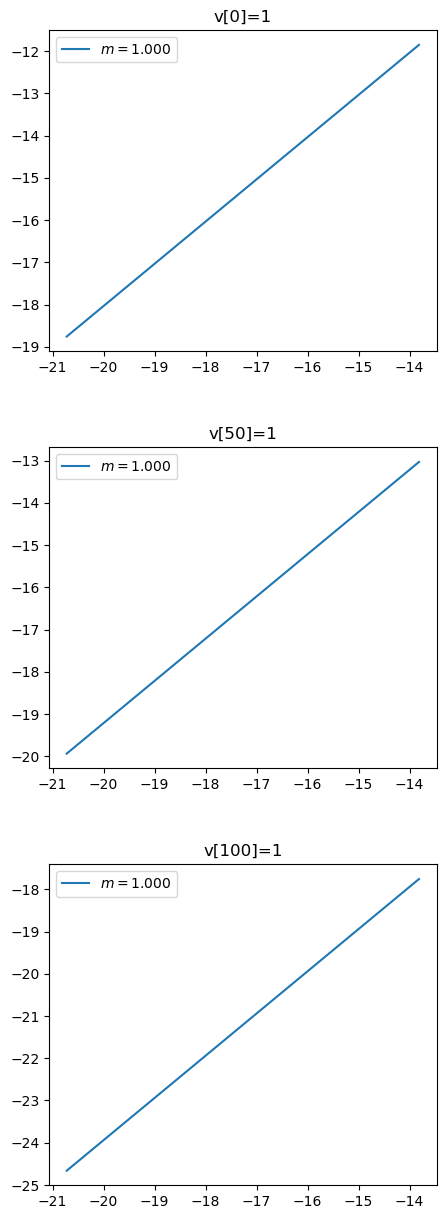

In [25]:
# Check ejbb_residual function
fig, ax = plt.subplots(3, 1, figsize=(5, 15))
plt.subplots_adjust(hspace=0.3)

sperm = Sperm2D()
kappa = sperm.preferred_curvature(0)
delta_s = np.zeros(sperm.N_flag)
delta_s[0] = 1.1*sperm.a + 0.5*sperm.Delta_L
delta_s[1:] = sperm.Delta_L
for i in range(50):
    sperm.theta[i+1] = sperm.theta[i] + np.arcsin(delta_s[i]*kappa[i])
sperm.Y = sperm.reconstruct_midpoints([0, 0], sperm.theta)
X = Xp = Xpp = pack_state(sperm.Y[0], sperm.theta, sperm.Lambda)
t = 0
dt = 1
L_x = L_y = 1000
N_x = N_y = 3000
sigma_D = sigma_T = 3
eta = 1
F_S = 300
chi = 1.1
v = np.zeros(X.shape)
epsilon = np.linspace(1e-9, 1e-6, 200)
f2_array = np.zeros(200)
for j in range(3):
    v = np.zeros(X.shape)
    v[50*j] = 1
    for i in range(200):
        f = ejbb_residual(
            X+epsilon[i]*v, Xp, Xpp,       
            sperm,            
            t, dt,            
            L_x, L_y,         
            N_x, N_y,         
            sigma_D, sigma_T, 
            eta,              
            F_S, chi)
        f2_array[i] = np.sum(f*f)**0.5
    x = np.log(epsilon)
    y = np.log(f2_array)
    grad = (y[-1]-y[0]) / (x[-1]-x[0])
    ax[j].plot(x, y, label=f'$m={grad:.3f}$')
    ax[j].set_title(f"v[{50*j}]=1")
    ax[j].legend()
plt.show()

In [26]:
def make_J0(sperm, dt, eta):
    """
    Build the block‑diagonal approximate Jacobian J0 for EJB‑b.

    The ordering of unknowns:
    [Y1_x, Y1_y, theta_0, ..., theta_(Nflag+1), Lambda_3/2, ..., Lambda_(Nflag+1/2)]
    Total dim = 2 + (Nflag+1) + 2*Nflag = 3*Nflag + 3

    Free-boundary conditions are applied.

    Parameters
    ----------
    sperm: an instance of Sperm2D class
    dt, eta, : floats
        timestep and fluid viscosity respectively.

    Returns
    -------
    J0 : ndarray, shape (3*Nflag+3, 3*Nflag+3)
        Block‑diagonal approximate Jacobian.
    """

    # Define repeatedly used variables
    Nflag = sperm.N_flag
    sin_hi = np.sin(sperm.theta[1:])
    sin_lo = np.sin(sperm.theta[:-1])
    cos_hi = np.cos(sperm.theta[1:])
    cos_lo = np.cos(sperm.theta[:-1])
    
    # 1) The Y1 blocks
    J_13 = -dt/(9*np.pi*eta*sperm.radii[0])*np.eye(2, 2*Nflag)

    # 2) angles block (Nflag+1 x Nflag+1)
    theta_bc = np.empty(Nflag+3)
    theta_bc[1:-1] = sperm.theta
    theta_bc[0] = sperm.theta[0] # ghost tip
    theta_bc[-1] = sperm.theta[-1] # ghost tail
    
    t_cross_Lambda = np.sin(sperm.theta)*(sperm.Lambda[1:, 1] + sperm.Lambda[:-1, 1])
    t_cross_Lambda += np.cos(sperm.theta)*(sperm.Lambda[1:, 0] + sperm.Lambda[:-1, 0])
    
    J_22 = -np.diag((np.cos(sperm.theta-theta_bc[:-2]) + np.cos(theta_bc[2:]-sperm.theta))/(sperm.lengths*sperm.radii**3))
    J_22 += np.diag(np.cos(sperm.theta[1:]-sperm.theta[:-1])/((sperm.lengths*sperm.radii**3)[1:]), k=-1)
    J_22 += np.diag(np.cos(sperm.theta[1:]-sperm.theta[:-1])/((sperm.lengths*sperm.radii**3)[:-1]), k=1)
    J_22 *= sperm.K_B
    J_22 -= 0.5*np.diag(sperm.lengths*t_cross_Lambda/sperm.radii**3)
    J_22 *= -dt/(12*np.pi*eta)
    J_22 += np.eye(Nflag+1)

    J_23 = np.zeros((Nflag+1, 2*Nflag), dtype=float)
    idxm_23 = np.arange(Nflag+1)
    idxn_23 = np.arange(2*Nflag)
    J_23[idxm_23[1:], idxn_23[::2]] -= sin_hi*((sperm.lengths/sperm.radii**3)[1:])
    J_23[idxm_23[:-1], idxn_23[::2]] -= sin_lo*((sperm.lengths/sperm.radii**3)[:-1])
    J_23[idxm_23[1:], idxn_23[1::2]] += cos_hi*((sperm.lengths/sperm.radii**3)[1:])
    J_23[idxm_23[:-1], idxn_23[1::2]] += cos_lo*((sperm.lengths/sperm.radii**3)[:-1])
    J_23 *= dt/(24*np.pi*eta)
    
    # 3) constraint (interior Lambda) block (2*Nflag scalars)
    J_32 = np.zeros((2*Nflag, Nflag+1), dtype=float)
    idxm_32 = np.arange(2*Nflag)
    idxn_32 = np.arange(Nflag+1)
    J_32[idxm_32[::2], idxn_32[:-1]] -= np.cumsum(sin_lo)
    J_32[idxm_32[::2], idxn_32[1:]] -= np.cumsum(sin_hi)
    J_32[idxm_32[1::2], idxn_32[:-1]] += np.cumsum(cos_lo)
    J_32[idxm_32[1::2], idxn_32[1:]] += np.cumsum(cos_hi)
    J_32 *= 0.5*sperm.lengths[1]

    J_33 = dt/(9*np.pi*eta*sperm.radii[1])*(np.eye(2*Nflag) - np.eye(2*Nflag, k=1))
    
    # 4) Putting all 9 blocks together into the Jacobian
    dim = 3*Nflag + 3
    J0 = np.zeros((dim, dim), dtype=float)

    #Define slice objects
    block_1 = slice(2)
    block_2 = slice(2, Nflag+3)
    block_3 = slice(Nflag+3, None)
    
    # First row
    J0[block_1, block_1] = np.eye(2)
    J0[block_1, block_3] = J_13

    # Second row
    J0[block_2, block_2] = J_22
    J0[block_2, block_3] = J_23

    # Third row
    J0[block_3, block_1] = np.eye(2*Nflag, 2)
    J0[block_3, block_2] = J_32
    J0[block_3, block_3] = J_33
    
    return J0

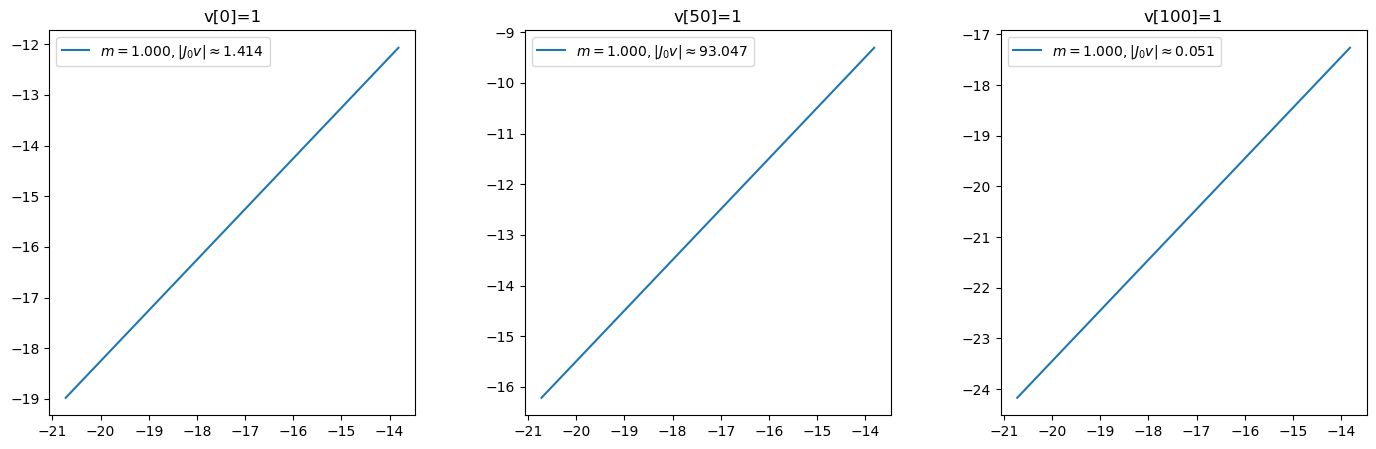

In [38]:
# Check make_J0 function
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
plt.subplots_adjust(wspace=0.3)

sperm = Sperm2D()
kappa = sperm.preferred_curvature(0)
delta_s = np.zeros(sperm.N_flag)
delta_s[0] = 1.1*sperm.a + 0.5*sperm.Delta_L
delta_s[1:] = sperm.Delta_L
for i in range(50):
    sperm.theta[i+1] = sperm.theta[i] + np.arcsin(delta_s[i]*kappa[i])
sperm.Y = sperm.reconstruct_midpoints([0, 0], sperm.theta)
X = Xp = Xpp = pack_state(sperm.Y[0], sperm.theta, sperm.Lambda)
t = 0
dt = 1
L_x = L_y = 1000
N_x = N_y = 3000
sigma_D = sigma_T = 3
eta = 1
F_S = 300
chi = 1.1
epsilon = np.linspace(1e-9, 1e-6, 100)
diff_array = np.zeros(100)
J0 = make_J0(sperm, dt, eta)
for j in range(3):
    v = np.zeros(X.shape)
    v[50*j] = 1
    Delta_f = J0@v
    approx_Jv = np.sum(Delta_f*Delta_f)**0.5
    for i in range(100):
        f = ejbb_residual(
            X+epsilon[i]*v, Xp, Xpp,       
            sperm,            
            t, dt,            
            L_x, L_y,         
            N_x, N_y,         
            sigma_D, sigma_T, 
            eta,              
            F_S, chi)
        diff_array[i] = np.sum(f*f)**0.5 - epsilon[i]*approx_Jv
    x = np.log(epsilon)
    y = np.log(np.abs(diff_array))
    grad = (y[-1]-y[-10]) / (x[-1]-x[-10])
    ax[j].plot(x, y, label=f'$m={grad:.3f}, |J_0 v|\\approx{approx_Jv:.3f}$')
    ax[j].set_title(f"v[{50*j}]=1")
    ax[j].legend()
plt.show()